Welcome to Santiago's Jupyter Notebook for accessing climate data. This script was created with the help of the original script provided by the course instructor for Royal Roads ENSC304- Earth and Atmospheric Science found [here](https://github.com/mbexhrs3/UCW-Project/blob/master/RRU-2021_UCW_project_Sept_2021.ipynb). Further aid was used from a tutorial [found here](https://www.ubcenvision.com/blog/2017/11/30/jupyter-part1.html). 

# Library Imports
As with any other python script, first we need to import the necessary libraries. Keep in mind that if you are using this script in your local environment, you may need to install the libraries before execution using either pip or conda.

In [1]:
import pandas as pd
import datetime
from datetime import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pymannkendall as mk
from mk_test import mk_test


# Functions
Functions in python are a great way to be able to re-use code, avoid lenghty and redundant code. For our case, I created three different functions that allow us to find stations based on the station ids which can be found in this website.

### Station Metadata Function
This function uses the environment canada API to access the station metadata. The function returns a dataframe with the station properties. This includes the types of data available, data ranges, coordinates, and other useful information.

In [432]:
def stationmetadata(s_id):
    # Start with an empty dictionary to add data to
    station_props = []
    url = "https://api.weather.gc.ca/collections/climate-stations/items?f=json&lang=en-CA&limit=10&STN_ID={}".format(
        s_id
    )
    # Now the headers needed to recieve the application format. In this case, the data arrives in geojson (json)
    headers = {"ACCEPT": "application/geo+json"}
    # Send a GET request to the API
    request = requests.get(url, headers=headers)
    request_json = request.json()
    print(request_json)
    # Get the properties of the stations
    data = request_json['features'][0]['properties']
    # Create a dataframe from the json data
    station_df = pd.json_normalize(data)
    station_props.append(station_df)
    # Concatenate the stations to the stations dataframe
    stations_df = pd.concat(station_props)
    return stations_df

In [4]:
station_numbers = [1070, 636, 888]
test = stationmetadata(station_numbers)


{'code': 'NoApplicableCode', 'description': 'query error (check logs)'}


KeyError: 'features'

Let's test the function to make sure that it works.

In [434]:
coast_meta = stationmetadata(888)
central_meta = stationmetadata(588)
southern_meta = stationmetadata(1032)

station_metadata = pd.concat([coast_meta, central_meta, southern_meta], ignore_index=True)
station_metadata


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'STN_ID': 888, 'STATION_NAME': 'VANCOUVER HARBOUR CS', 'PROV_STATE_TERR_CODE': 'BC', 'ENG_PROV_NAME': 'BRITISH COLUMBIA', 'FRE_PROV_NAME': 'COLOMBIE-BRITANNIQUE', 'COUNTRY': 'CAN', 'LATITUDE': 491743270, 'LONGITUDE': -1230718730, 'TIMEZONE': 'PST', 'ELEVATION': '2.50', 'CLIMATE_IDENTIFIER': '1108446', 'TC_IDENTIFIER': 'WHC', 'WMO_IDENTIFIER': '71201', 'STATION_TYPE': 'Climate-Auto', 'NORMAL_CODE': 'D', 'PUBLICATION_CODE': 1, 'DISPLAY_CODE': 5, 'ENG_STN_OPERATOR_ACRONYM': 'ECCC - MSC', 'FRE_STN_OPERATOR_ACRONYM': 'ECCC - SMC', 'ENG_STN_OPERATOR_NAME': 'Environment and Climate Change Canada - Meteorological Service of Canada', 'FRE_STN_OPERATOR_NAME': 'Environnement et Changement climatique Canada - Service météorologique du Canada', 'FIRST_DATE': '1925-01-01 00:00:00', 'LAST_DATE': '2023-02-24 08:30:08', 'HLY_FIRST_DATE': '1976-01-20 07:00:00', 'HLY_LAST_DATE': '2023-02-24 08:30:08', 'DLY_FIRST_DATE': '1925-11

,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,ELEVATION,...,LAST_DATE,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA
0,888,VANCOUVER HARBOUR CS,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,491743270,-1230718730,PST,2.50,...,2023-02-24 08:30:08,1976-01-20 07:00:00,2023-02-24 08:30:08,1925-11-01 00:00:00,2023-02-23 00:00:00,1925-01-01 00:00:00,2007-02-01 00:00:00,Y,N,Y
1,588,FORT ST JAMES,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,542719009,-1241708002,PST,691.00,...,2019-05-08 00:00:00,None,None,1895-01-01 00:00:00,2019-05-08 00:00:00,1895-01-01 00:00:00,2007-02-01 00:00:00,Y,Y,N
2,1032,OKANAGAN CENTRE,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,500322100,-1192642400,PST,370.00,...,2022-05-22 00:00:00,None,None,1925-03-01 00:00:00,2022-05-22 00:00:00,1925-01-01 00:00:00,2007-02-01 00:00:00,Y,N,N


### Get Data function
This function is used for downloading the available data from the environment canada historical data api, based on a station ID and a start year. The result of this function is a dataframe built from a csv downloaded.

In [438]:
def getData(stationID, year, month):
    #Build the URL for query
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month=1&timeframe=2".format(stationID, year)
    api_endpoint = base_url + query_url
    print(api_endpoint)
    # Create a dataframe by reading the csv
    return pd.read_csv(api_endpoint, skiprows=0)
    



### Station Data function
This function used the previous two functions to create a dataframe from provided station IDs. Then, the function looks for stations which have monthly data available, finds the data date ranges, and uses those results to download the available data.

In [440]:
from dateutil import rrule
def get_station_data(station_id):
    frames = []
    for stn in station_id:
      print(stn)
      station_meta = stationmetadata(stn)
        
      start_date_full = station_meta.query('STN_ID == @stn').iloc[0]['DLY_FIRST_DATE']
      

      end_date_full = station_meta.query('STN_ID == @stn').iloc[0]['DLY_LAST_DATE']
      

      start_date = datetime.strptime(start_date_full, '%Y-%m-%d %H:%M:%S')
      
      end_date = datetime.strptime(end_date_full, '%Y-%m-%d %H:%M:%S')
      
      for dt in mdates.rrule(rrule.YEARLY, dtstart=start_date, until=end_date):
        df = getData(stationID=stn, year=dt.year, month=dt.month)
        frames.append(df)

    return frames
    


# Accesing the Data
In this section, we demosntrate how to recieve a user input for station IDs, and then use that for accessing the data using our functions above.

In [473]:
input_id = input("Please enter the station separated by a space: ")
station_ids = input_id.split()
stations = [int(station) for station in station_ids]
print(stations)
#731
weather_data_compiled = get_station_data(stations)


[889, 588, 1032, 51442]
889
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'STN_ID': 889, 'STATION_NAME': "VANCOUVER INT'L A", 'PROV_STATE_TERR_CODE': 'BC', 'ENG_PROV_NAME': 'BRITISH COLUMBIA', 'FRE_PROV_NAME': 'COLOMBIE-BRITANNIQUE', 'COUNTRY': 'CAN', 'LATITUDE': 491142000, 'LONGITUDE': -1231055000, 'TIMEZONE': 'PST', 'ELEVATION': '4.30', 'CLIMATE_IDENTIFIER': '1108447', 'TC_IDENTIFIER': 'YVR', 'WMO_IDENTIFIER': None, 'STATION_TYPE': 'Aviation-Staffed', 'NORMAL_CODE': 'A', 'PUBLICATION_CODE': 1, 'DISPLAY_CODE': 1, 'ENG_STN_OPERATOR_ACRONYM': None, 'FRE_STN_OPERATOR_ACRONYM': None, 'ENG_STN_OPERATOR_NAME': None, 'FRE_STN_OPERATOR_NAME': None, 'FIRST_DATE': '1937-01-01 00:00:00', 'LAST_DATE': '2013-06-13 10:00:00', 'HLY_FIRST_DATE': '1953-01-01 00:00:00', 'HLY_LAST_DATE': '2013-06-13 10:00:00', 'DLY_FIRST_DATE': '1937-01-01 00:00:00', 'DLY_LAST_DATE': '2013-06-12 00:00:00', 'MLY_FIRST_DATE': '1937-01-01 00:00:00', 'MLY_LAST_DATE': '2013-06-01 00:00:00', 'H

In [474]:
weather_dataframe = pd.concat(weather_data_compiled)
weather_dataframe

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-123.18,49.20,VANCOUVER INT'L A,1108447,1937-01-01,1937,1,1,NaN,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-123.18,49.20,VANCOUVER INT'L A,1108447,1937-01-02,1937,1,2,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-123.18,49.20,VANCOUVER INT'L A,1108447,1937-01-03,1937,1,3,NaN,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-123.18,49.20,VANCOUVER INT'L A,1108447,1937-01-04,1937,1,4,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-123.18,49.20,VANCOUVER INT'L A,1108447,1937-01-05,1937,1,5,NaN,-1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-123.18,49.19,VANCOUVER INTL A,1108395,2022-12-27,2022,12,27,NaN,9.8,...,0.0,NaN,28.8,NaN,NaN,NaN,25.0,NaN,46.0,NaN
361,-123.18,49.19,VANCOUVER INTL A,1108395,2022-12-28,2022,12,28,NaN,8.1,...,0.0,NaN,3.8,NaN,NaN,NaN,23.0,NaN,46.0,NaN
362,-123.18,49.19,VANCOUVER INTL A,1108395,2022-12-29,2022,12,29,NaN,6.5,...,0.0,NaN,2.9,NaN,NaN,NaN,6.0,NaN,33.0,NaN
363,-123.18,49.19,VANCOUVER INTL A,1108395,2022-12-30,2022,12,30,NaN,10.4,...,0.0,NaN,12.7,NaN,NaN,NaN,14.0,NaN,39.0,NaN


Now let's make sure that we have the data we want by running a quick check of the station names

In [475]:
weather_dataframe['Station Name'].unique()
#weather_dataframe.drop_duplicates()

array(["VANCOUVER INT'L A", 'FORT ST JAMES', 'OKANAGAN CENTRE',
       'VANCOUVER INTL A'], dtype=object)

Explore the data that we just recieved, and find the first values after NAs

In [493]:
#Filter the data with dataframes
weather_data_vancouver = weather_dataframe.loc[(weather_dataframe['Station Name'] == 'VANCOUVER INT\'L A') | (weather_dataframe['Station Name'] =='VANCOUVER INTL A')]
weather_data_pg = weather_dataframe[weather_dataframe['Station Name'] == 'FORT ST JAMES']
weather_data_pencticton = weather_dataframe[weather_dataframe['Station Name'] == 'OKANAGAN CENTRE']

van_clean = weather_data_vancouver.drop_duplicates()
pg_clean = weather_data_pg.drop_duplicates()
penticton_clean = weather_data_pencticton.drop_duplicates()



## Data Quality
During this section, we can quickly explore the data, find NaN values, rename columns, and fill in empty values with median values.

In [494]:
# First lets make a quick function that will explore the data tables for us

def data_explorer(dataframe):
  print("The Head of the dataframe")
  print(dataframe.head())
  print("The Data description/summary")
  print(dataframe.describe())
  print("Null Values")
  print(dataframe.isnull().sum())

In [495]:

data_explorer(van_clean)


The Head of the dataframe
   Longitude (x)  Latitude (y)       Station Name  Climate ID   Date/Time  \
0        -123.18          49.2  VANCOUVER INT'L A     1108447  1937-01-01   
1        -123.18          49.2  VANCOUVER INT'L A     1108447  1937-01-02   
2        -123.18          49.2  VANCOUVER INT'L A     1108447  1937-01-03   
3        -123.18          49.2  VANCOUVER INT'L A     1108447  1937-01-04   
4        -123.18          49.2  VANCOUVER INT'L A     1108447  1937-01-05   

   Year  Month  Day Data Quality  Max Temp (°C)  ... Total Snow (cm)  \
0  1937      1    1          NaN            3.9  ...             NaN   
1  1937      1    2          NaN            0.0  ...             NaN   
2  1937      1    3          NaN            6.1  ...             NaN   
3  1937      1    4          NaN            5.0  ...             NaN   
4  1937      1    5          NaN           -1.1  ...             NaN   

   Total Snow Flag Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  \
0

In [496]:
# Here we get the features we want in our dataframe
features = ['Station Name', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Year', 'Month', 'Day', 'Mean Temp (°C)', 'Total Rain (mm)']
df_vancouver = van_clean[features]
df_vancouver.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)

df_pg = pg_clean[features]
df_pg.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)

df_pencticton = penticton_clean[features]
df_pencticton.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)



C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1913057348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vancouver.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1913057348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pg.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1913057348.py:12: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [497]:
df_vancouver.isnull().sum()

Station_Name      0
Climate ID        0
lon               0
lat               0
Year              0
Month             0
Day               0
Mean_Temp       436
Total_Rain      472
dtype: int64

In [498]:
df_pg.isnull().sum()

Station_Name       0
Climate ID         0
lon                0
lat                0
Year               0
Month              0
Day                0
Mean_Temp       1974
Total_Rain      1926
dtype: int64

In [499]:
df_pencticton.isnull().sum()

Station_Name       0
Climate ID         0
lon                0
lat                0
Year               0
Month              0
Day                0
Mean_Temp       2363
Total_Rain      1694
dtype: int64

But how do we know where the null values end? A graph of the data provides us the fastest visual solution. We first need to add a datetime column for graphing.

## Now we want to summarize the data by month

In [504]:
df_vancouver['datetime'] = pd.to_datetime(df_vancouver[['Year', 'Month', 'Day']])
df_pg['datetime'] = pd.to_datetime(df_pg[['Year', 'Month', 'Day']])
df_pencticton['datetime'] = pd.to_datetime(df_pencticton[['Year', 'Month', 'Day']])

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3345714594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vancouver['datetime'] = pd.to_datetime(df_vancouver[['Year', 'Month', 'Day']])
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3345714594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pg['datetime'] = pd.to_datetime(df_pg[['Year', 'Month', 'Day']])
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3345714594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [543]:
df_van_monthly = np.round(df_vancouver.groupby(pd.PeriodIndex(df_vancouver['datetime'], freq="M"))['Mean_Temp', 'Total_Rain'].mean().reset_index(), 2)
df_van_monthly['Year'] = df_van_monthly['datetime'].dt.year
df_van_monthly['Month'] = df_van_monthly['datetime'].dt.month
df_van_monthly['datetime'] = pd.to_datetime(df_van_monthly[['Year', 'Month']].assign(DAY=1))

df_central_monthly = np.round(df_pg.groupby(pd.PeriodIndex(df_pg['datetime'], freq="M"))['Mean_Temp', 'Total_Rain'].mean().reset_index(), 2)
df_central_monthly['Year'] = df_central_monthly['datetime'].dt.year
df_central_monthly['Month'] = df_central_monthly['datetime'].dt.month
df_central_monthly['datetime'] = pd.to_datetime(df_central_monthly[['Year', 'Month']].assign(DAY=1))

df_southern_monthly = np.round(df_pencticton.groupby(pd.PeriodIndex(df_pencticton['datetime'], freq="M"))['Mean_Temp', 'Total_Rain'].mean().reset_index(), 2)
df_southern_monthly['Year'] = df_southern_monthly['datetime'].dt.year
df_southern_monthly['Month'] = df_southern_monthly['datetime'].dt.month
df_southern_monthly['datetime'] = pd.to_datetime(df_southern_monthly[['Year', 'Month']].assign(DAY=1))

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3674821490.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_van_monthly = np.round(df_vancouver.groupby(pd.PeriodIndex(df_vancouver['datetime'], freq="M"))['Mean_Temp', 'Total_Rain'].mean().reset_index(), 2)
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3674821490.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_central_monthly = np.round(df_pg.groupby(pd.PeriodIndex(df_pg['datetime'], freq="M"))['Mean_Temp', 'Total_Rain'].mean().reset_index(), 2)
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3674821490.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_southern_monthly = np.round(df_pencticton.groupby(pd.PeriodIndex(df_pencticton['datetime'], freq="M"))['Mean_Temp', 'Total

In [539]:
df_van_monthly

,datetime,Mean_Temp,Total_Rain,Year,Month
0,1937-01-01,-3.77,0.40,1937,1
1,1937-02-01,1.95,3.68,1937,2
2,1937-03-01,7.31,1.92,1937,3
3,1937-04-01,8.40,3.80,1937,4
4,1937-05-01,11.47,1.43,1937,5
...,...,...,...,...,...
1027,2022-08-01,19.80,0.21,2022,8
1028,2022-09-01,16.02,0.23,2022,9
1029,2022-10-01,12.05,2.86,2022,10
1030,2022-11-01,3.93,3.39,2022,11


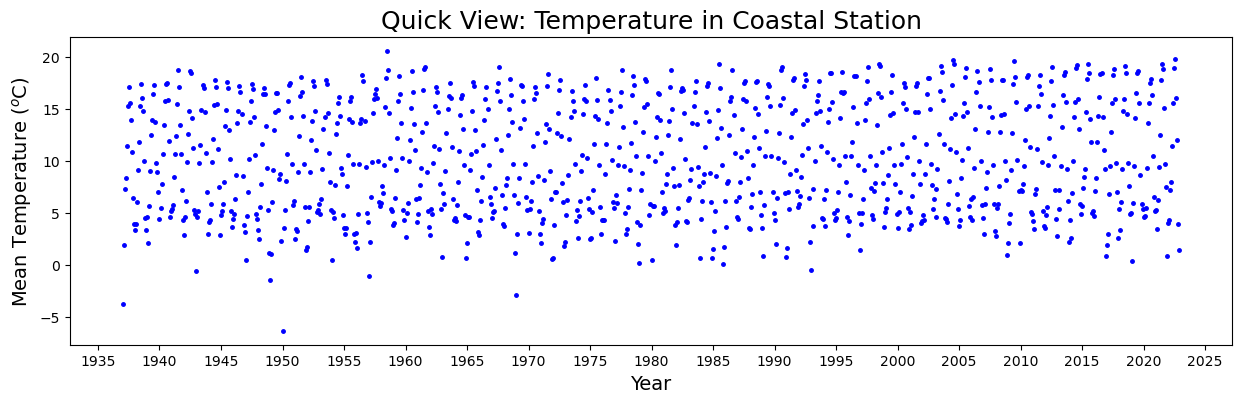

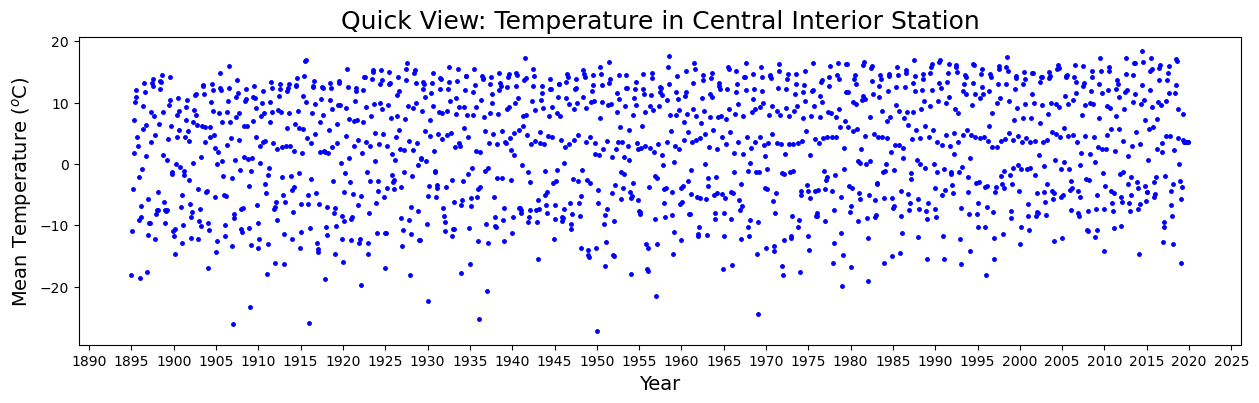

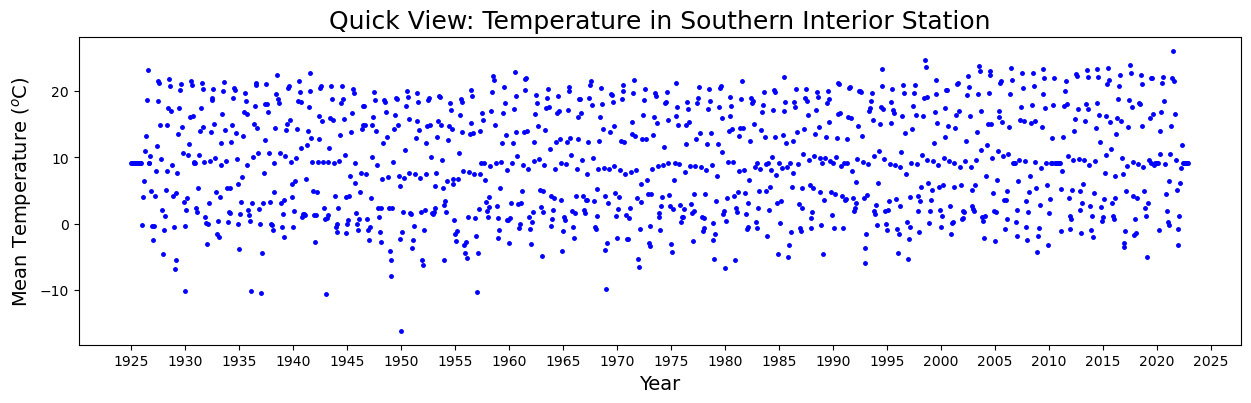

In [716]:
def graph_temp(dataframe):
  fig = plt.figure(figsize=(15,4))
  ax = fig.add_subplot(111)
  ax.plot(dataframe['datetime'],dataframe['Mean_Temp'], marker='.', markersize=5, color='b', linestyle='None')

  loc = mdates.YearLocator(5)
  ax.xaxis.set_major_locator(loc)
  fmt = mdates.DateFormatter('%Y')
  ax.xaxis.set_major_formatter(fmt)

  plt.xlabel('Year', fontsize=14)
  plt.ylabel('Mean Temperature ($^o$C)', fontsize=14)
  plot_title = input('Please write the name of the graph:')
  plt.title('Quick View: Temperature in {}'.format(plot_title), fontsize=18)
  plt.axis('tight')
  plt.show()

graph_temp(df_van_monthly)
graph_temp(df_central_monthly)
graph_temp(df_southern_monthly)

Now we will do the same with precipitation

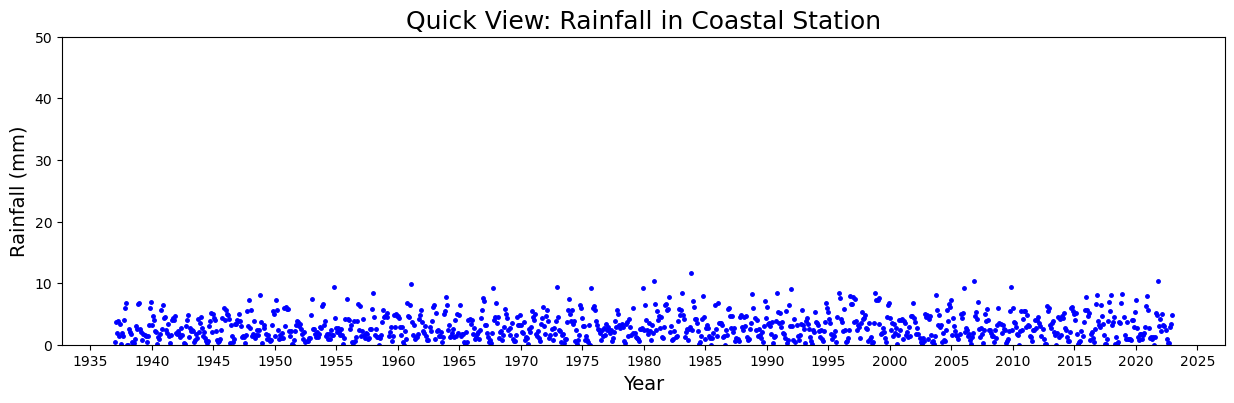

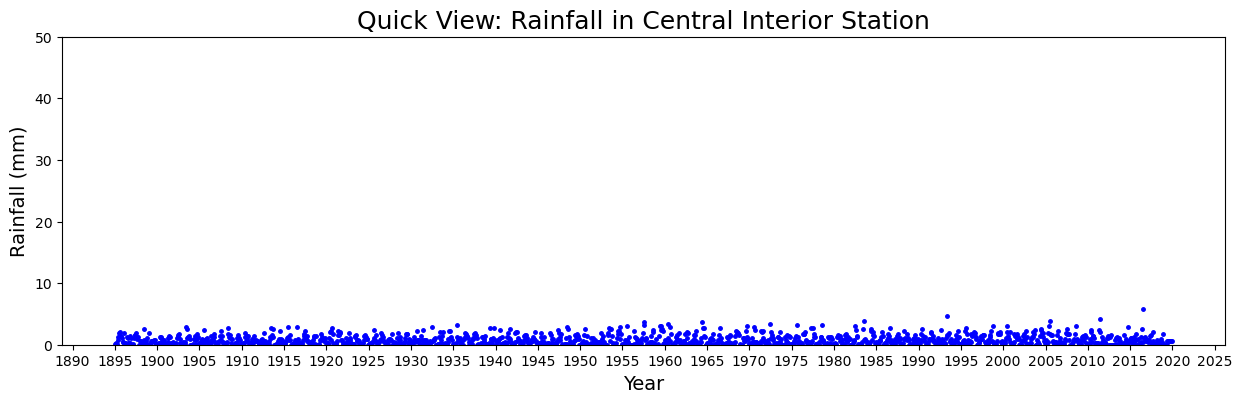

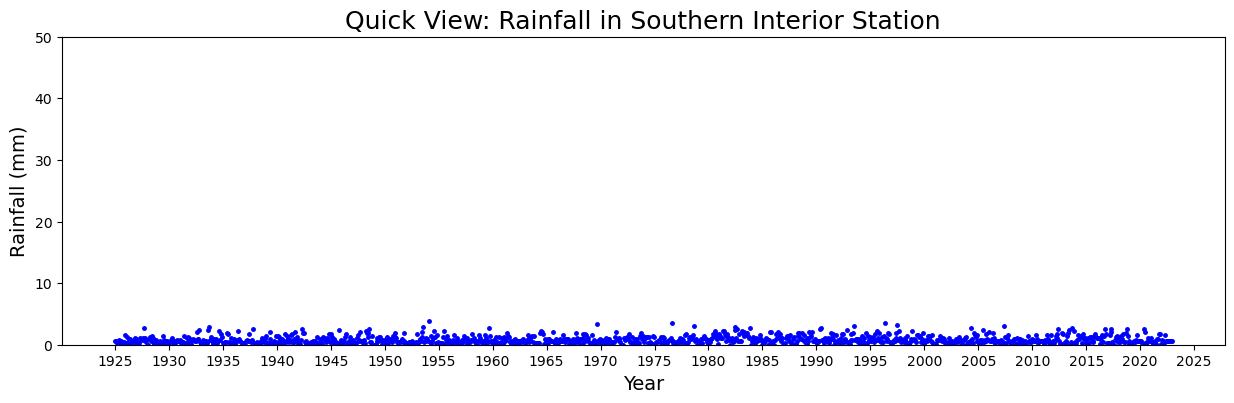

In [717]:
def graph_precip(dataframe):
  x = np.arange(912)
  fig = plt.figure(figsize=(15,4))
  ax = fig.add_subplot(111)
  ax.plot(dataframe['datetime'],dataframe['Total_Rain'],marker='.',markersize=5,color='b',linestyle='None')

  loc = mdates.YearLocator(5)
  ax.xaxis.set_major_locator(loc)
  fmt = mdates.DateFormatter('%Y')
  ax.xaxis.set_major_formatter(fmt)
  ax.set_ylim([0,50])

  plt.xlabel('Year',fontsize=14)
  plt.ylabel('Rainfall (mm)',fontsize=14)
  plot_title = input('Please write the name of the graph:')
  plt.title('Quick View: Rainfall in {}'.format(plot_title), fontsize=18)

  plt.show()

graph_precip(df_van_monthly)
graph_precip(df_central_monthly)
graph_precip(df_southern_monthly)


Results of whether to fill with

### Fill in empty values
Here we created another function which will automatically fill empty columns with the median values based on columns of interest.

In [548]:
def fill_empty(columns, dataframe):
    for column in columns:
        dataframe[column].fillna(dataframe[column].median(), inplace=True)
    return dataframe


columns_interest = ('Total_Rain', 'Mean_Temp')

working_data_vancouver = fill_empty(columns_interest, df_van_monthly)
working_data_pg = fill_empty(columns_interest, df_central_monthly)
working_data_pencticton = fill_empty(columns_interest, df_southern_monthly)


working_data_vancouver.isnull().sum()
working_data_pg.isnull().sum()
working_data_pencticton.isnull().sum()

datetime      0
Mean_Temp     0
Total_Rain    0
Year          0
Month         0
dtype: int64

Regraph to check if the values were done nicely

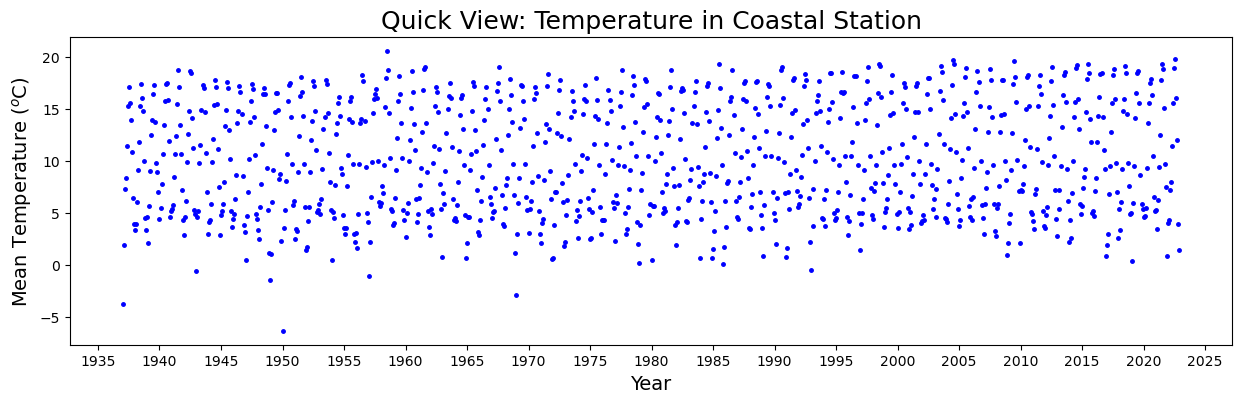

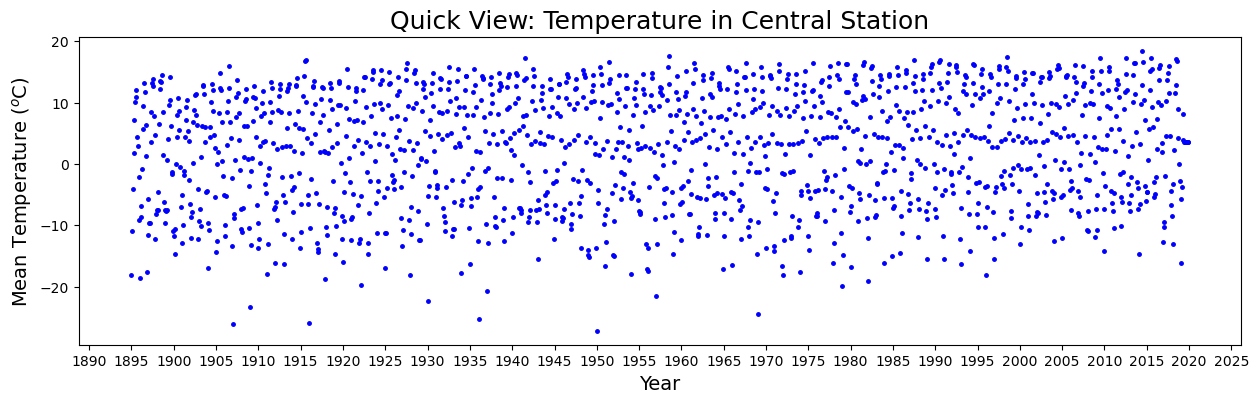

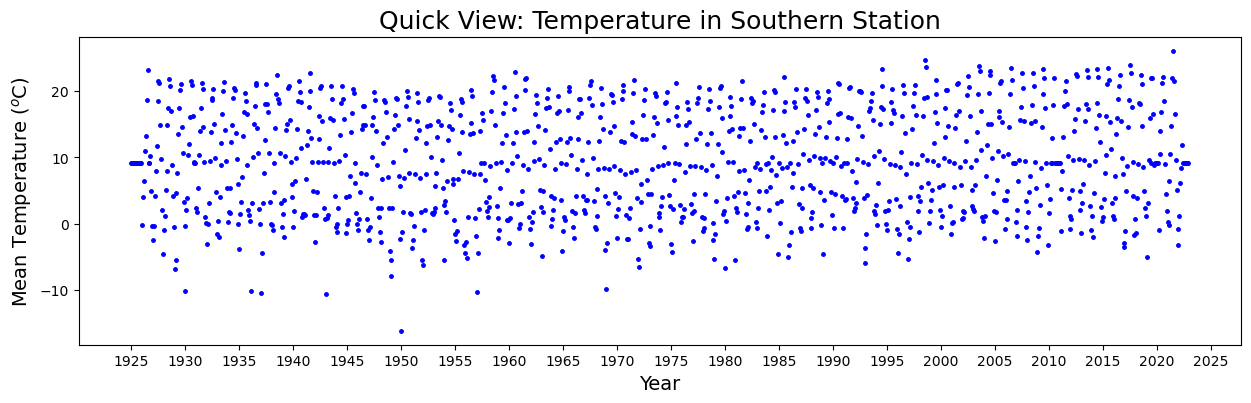

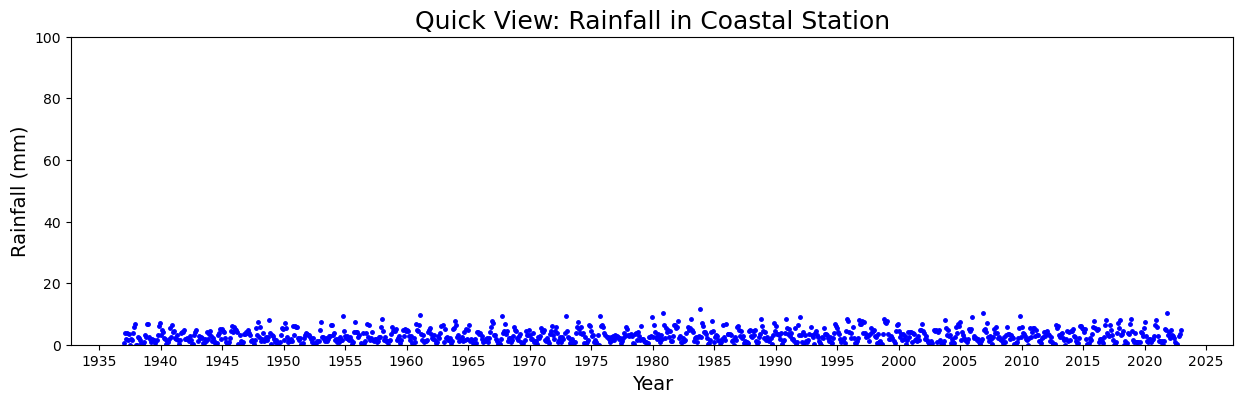

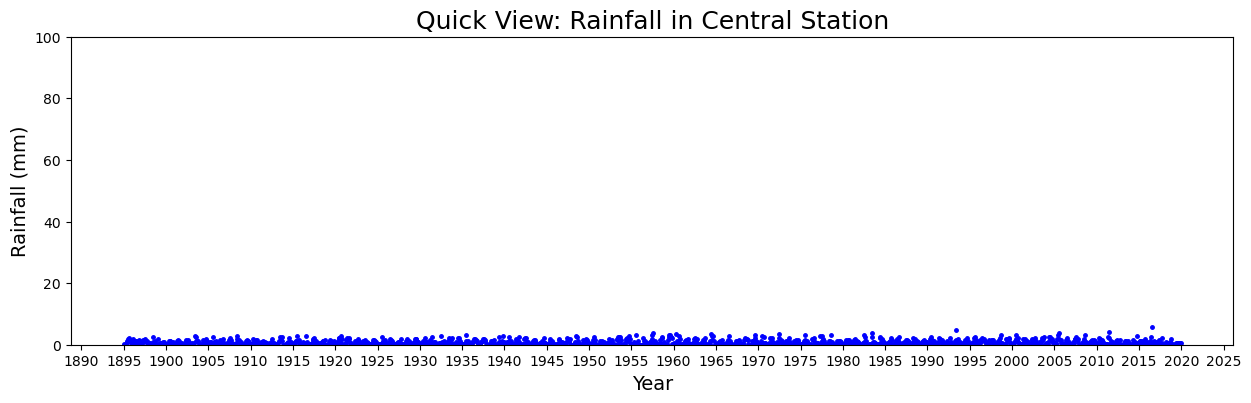

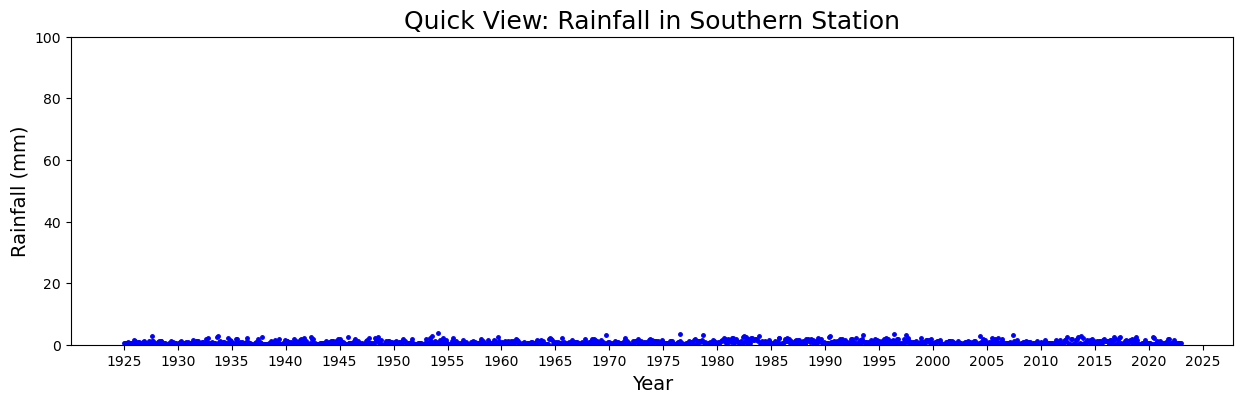

In [550]:
graph_temp(working_data_vancouver)
graph_temp(working_data_pg)
graph_temp(working_data_pencticton)

graph_precip(working_data_vancouver)
graph_precip(working_data_pg)
graph_precip(working_data_pencticton)

#Mann-Kendall Test
In this section we apply the Mann Kendall Test to check for significance in a trend overtime.




In [551]:
mk_data_vancouver = working_data_vancouver.set_index('datetime')
mann_k_test_van_temp = mk.original_test(mk_data_vancouver['Mean_Temp'])
print("Vancouver Temp: ", mann_k_test_van_temp)

mann_k_test_van_precip = mk.original_test(mk_data_vancouver['Total_Rain'])
print("Vancouver Precip: ",mann_k_test_van_precip)

mk_data_pg = working_data_pg.set_index('datetime')
mann_k_test_pg_temp = mk.original_test(mk_data_pg['Mean_Temp'])
print("Prince George Temp: ",mann_k_test_pg_temp)

mann_k_test_pg_precip = mk.original_test(mk_data_pg['Total_Rain'])
print("Prince George Precip: ",mann_k_test_pg_precip)

mk_data_penticton = working_data_pencticton.set_index('datetime')
mann_k_test_penticton_temp = mk.original_test(mk_data_vancouver['Mean_Temp'])
print("Penticton Temp: ",mann_k_test_penticton_temp)

mann_k_test_penticton_precip = mk.original_test(mk_data_vancouver['Total_Rain'])
print("Penticton Precip: ",mann_k_test_penticton_precip)

Vancouver Temp:  Mann_Kendall_Test(trend='no trend', h=False, p=0.05568675708708182, z=1.9134790180412795, Tau=0.039778494575147184, s=21162.0, var_s=122299580.0, slope=0.0010061934345758543, intercept=9.136307284476148)
Vancouver Precip:  Mann_Kendall_Test(trend='increasing', h=True, p=0.023905891424381487, z=2.258638330924042, Tau=0.04695336055158309, s=24979.0, var_s=122298726.33333333, slope=0.0004521739130434783, intercept=2.341904347826087)
Prince George Temp:  Mann_Kendall_Test(trend='increasing', h=True, p=0.0003073076737214464, z=3.609060725486457, Tau=0.0621970202357127, s=69925.0, var_s=375373966.3333333, slope=0.001894736842105271, intercept=2.1798947368420993)
Prince George Precip:  Mann_Kendall_Test(trend='increasing', h=True, p=0.03837680531275223, z=2.0708073262731097, Tau=0.03563709139426284, s=40065.0, var_s=374308103.0, slope=3.2590992777227036e-05, intercept=0.5055730509134684)
Penticton Temp:  Mann_Kendall_Test(trend='no trend', h=False, p=0.05568675708708182, z=1.

## Data Visualization
During the first step of data visualization, we can explore the data to find gaps, places where the data looks funky, and get a quick overview of the data. The following section displays the data accessed from earlier.

### Note on data availability
As seen on the three graphs above, there are different date ranges for our three sites. We will now subset our dataframes into the years we want (1977-2007) so Penticton and Vancouver stations match with the Prince Georga statation.

In [567]:
coast_data = working_data_vancouver.set_index(['datetime'])
clean_coast_data = coast_data.loc['1938-01-01':'2022-12-12']

clean_central_data = working_data_pg.query('Year >= 1938 & Year <= 2022')
clean_interior_data = working_data_pencticton.query('Year >= 1938 & Year <= 2022')


### Now we can explore our cleaned data


In [568]:
print(clean_coast_data.__len__())

1020


In [569]:
months = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sep',
    10:'Oct',
    11:'Nov',
    12:'Dec'   
}
months.values()



dict_values(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Further Data Visualization and Analysis for each station.
Now that we have clean data for each one of our stations (Coastal, Central Interior, and Southern Interior), we can start graphing and looking at various different analyses of the data.

## Coastal Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

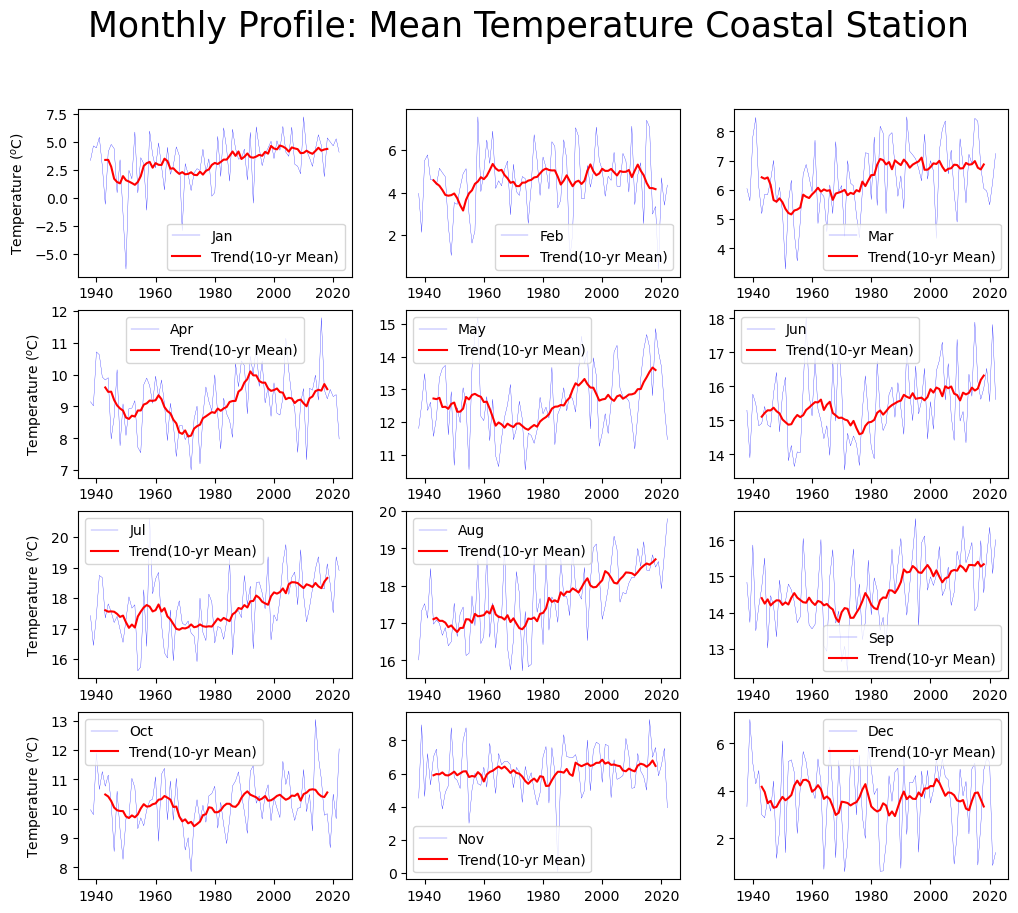

In [572]:
year_val = np.linspace(1938,2022, 85)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_coast_data[clean_coast_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature Coastal Station',fontsize=25)

    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

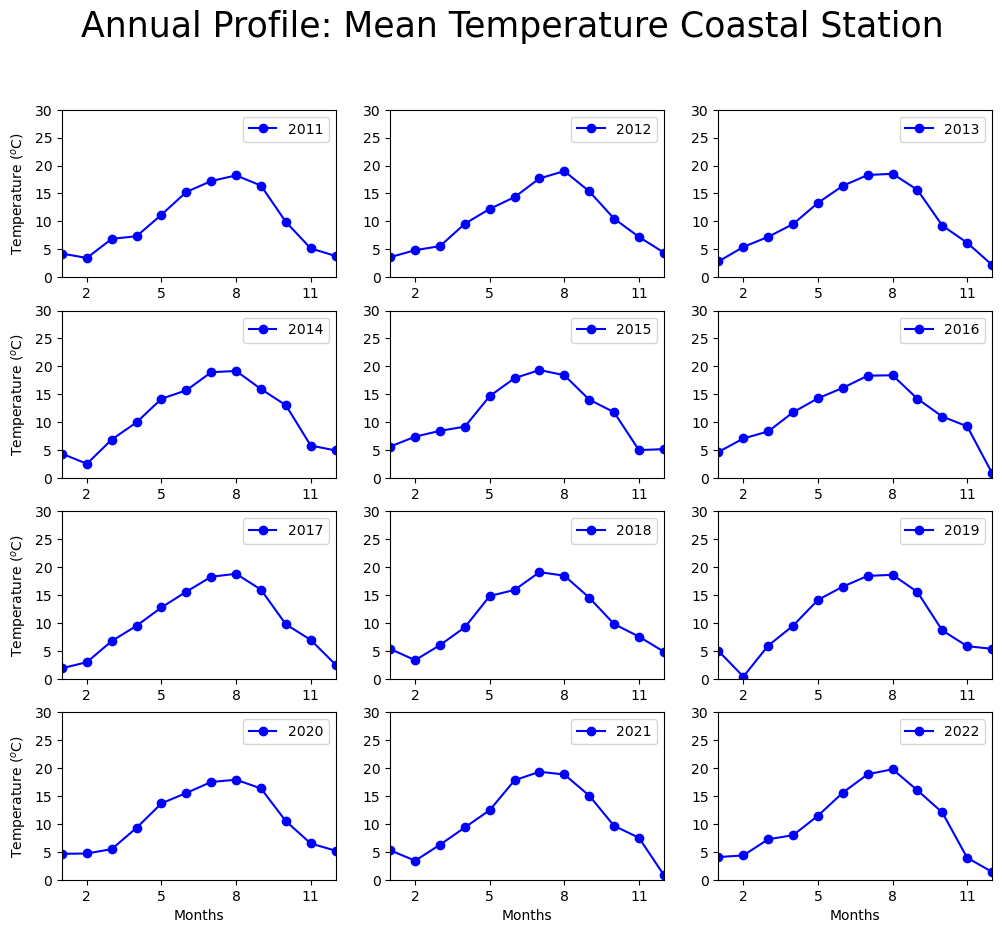

In [577]:
year = np.arange(2011,2023)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_coast_data[clean_coast_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature Coastal Station', fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

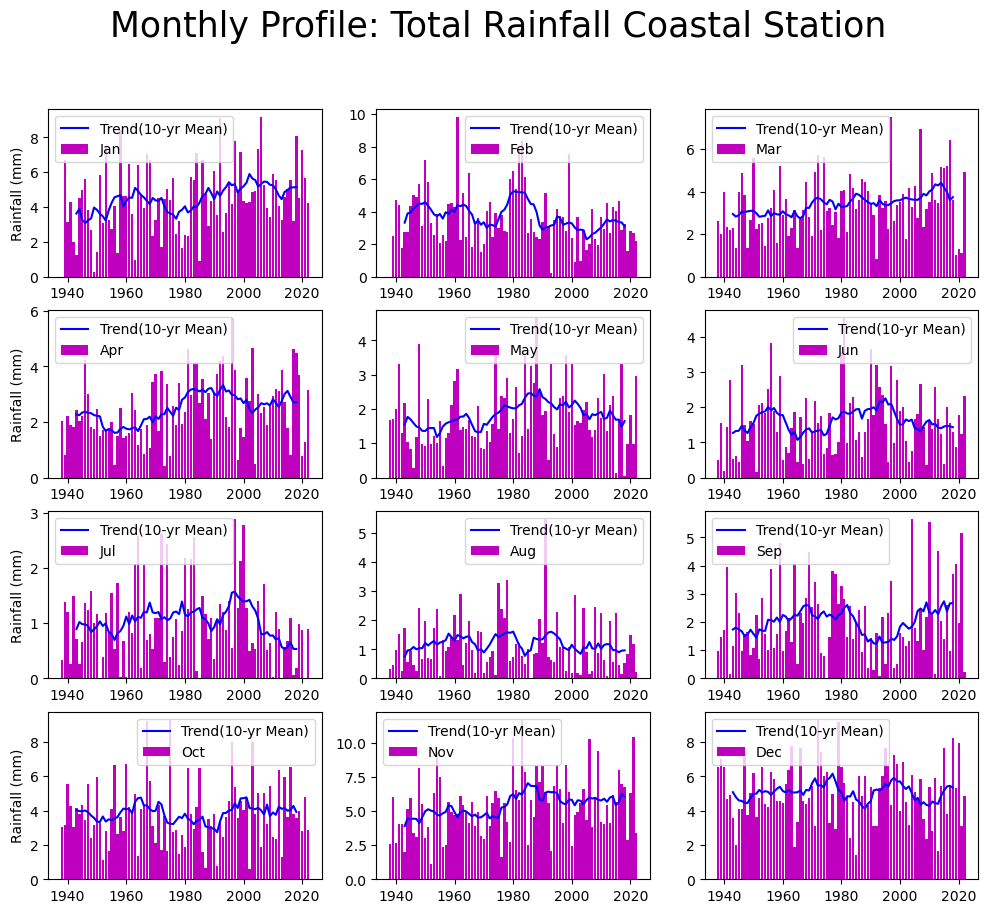

In [579]:
year_val = np.linspace(1938,2022,85)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_coast_data[clean_coast_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall Coastal Station',fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

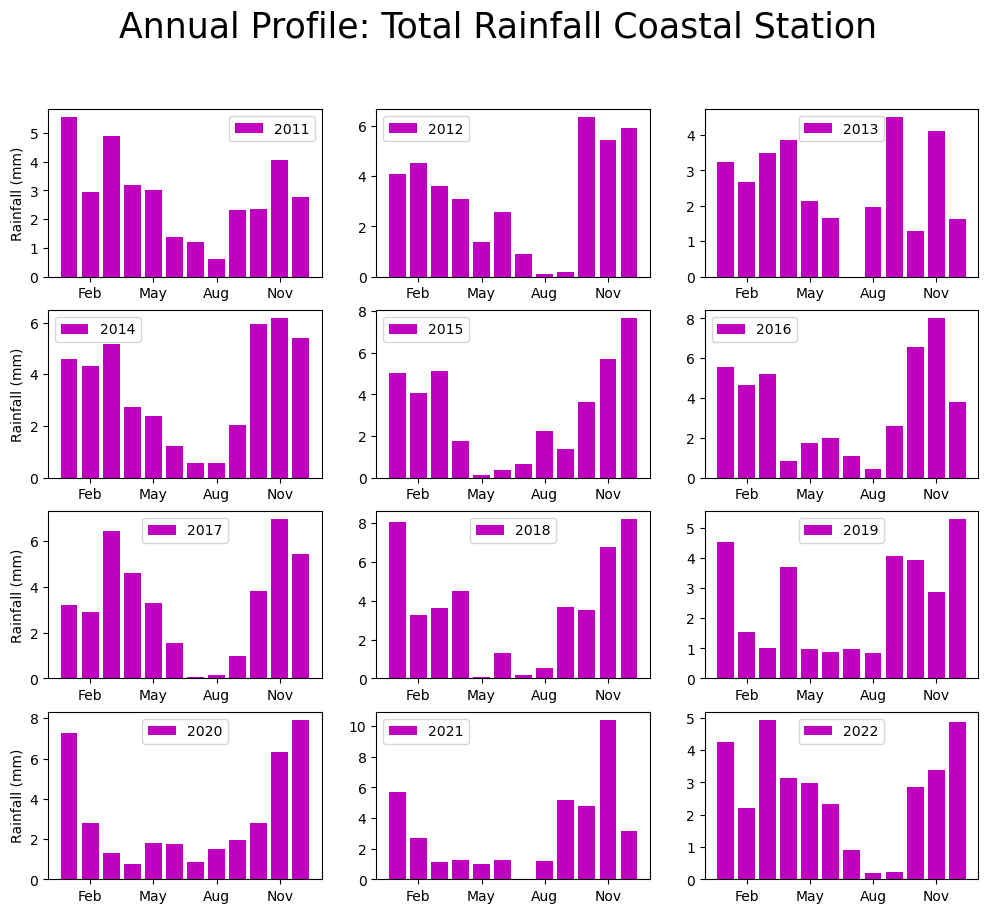

In [580]:
year = np.arange(2011,2023)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_coast_data[clean_coast_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall Coastal Station',fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [581]:
Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)

#### Mean Monthly Temperature

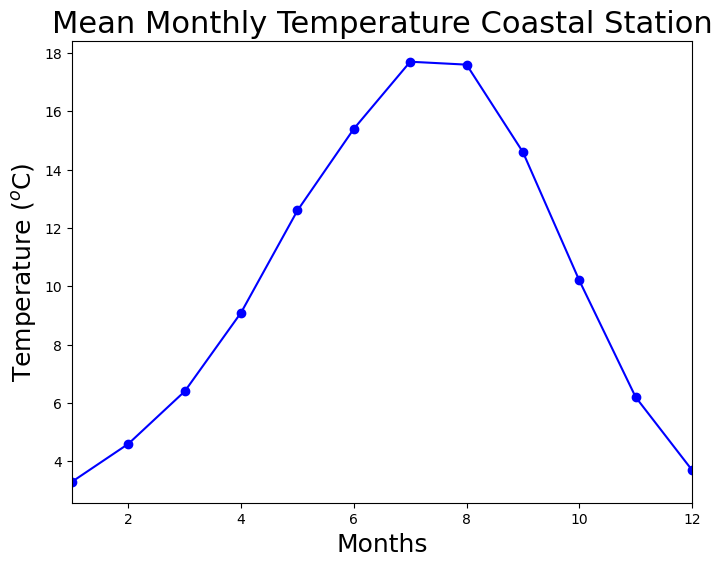

In [582]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature Coastal Station', fontsize=22)

plt.show()

#### Mean Monthly Rainfall

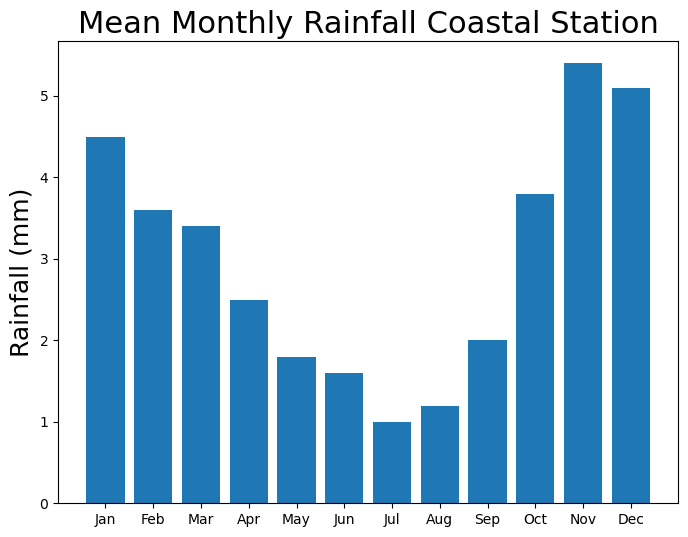

In [583]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall Coastal Station', fontsize=22)
plt.show()

### Seasonal Means

In [719]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_coast_data['season'] = [month_num_2_season.get(i) for i in clean_coast_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_coast_data.groupby('season').mean(),1)
seasonal_val
clean_coast_data

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3374549264.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_coast_data['season'] = [month_num_2_season.get(i) for i in clean_coast_data.Month]


,Mean_Temp,Total_Rain,Year,Month,season
datetime,,,,,
1938-01-01,3.33,0.00,1938,1,DJF
1938-02-01,3.97,0.00,1938,2,DJF
1938-03-01,6.05,2.61,1938,3,MAM
1938-04-01,9.15,2.04,1938,4,MAM
1938-05-01,11.81,1.69,1938,5,MAM
...,...,...,...,...,...
2022-08-01,19.80,0.21,2022,8,JJA
2022-09-01,16.02,0.23,2022,9,SON
2022-10-01,12.05,2.86,2022,10,SON


### Data Visualization 10 years

In [720]:
coastal_change = clean_coast_data[clean_coast_data['Year'] >= 1938]
coastal_change

,Mean_Temp,Total_Rain,Year,Month,season
datetime,,,,,
1938-01-01,3.33,0.00,1938,1,DJF
1938-02-01,3.97,0.00,1938,2,DJF
1938-03-01,6.05,2.61,1938,3,MAM
1938-04-01,9.15,2.04,1938,4,MAM
1938-05-01,11.81,1.69,1938,5,MAM
...,...,...,...,...,...
2022-08-01,19.80,0.21,2022,8,JJA
2022-09-01,16.02,0.23,2022,9,SON
2022-10-01,12.05,2.86,2022,10,SON


In [721]:
monthly_mean_recent = coastal_change.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1054089607.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = coastal_change.groupby('Month').mean()


,Mean_Temp,Total_Rain,Year
Month,,,
1,3.302471,4.473412,1980.0
2,4.563882,3.606588,1980.0
3,6.378000,3.356941,1980.0
4,9.148706,2.467412,1980.0
5,12.612000,1.824824,1980.0
6,15.444118,1.580235,1980.0
7,17.719882,1.007882,1980.0
8,17.629882,1.156824,1980.0
9,14.646824,2.022706,1980.0


#### Mean Temperature Change

In [722]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


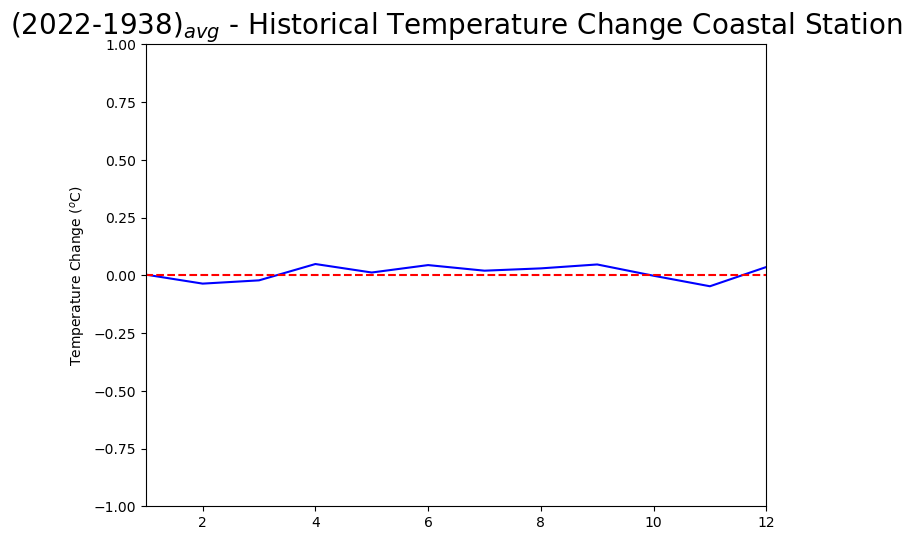

In [723]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-1,1)
ax.plot([0,12],[0,0],'r--')
plt.title('(2022-1938)$_{avg}$ - Historical Temperature Change Coastal Station', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [724]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

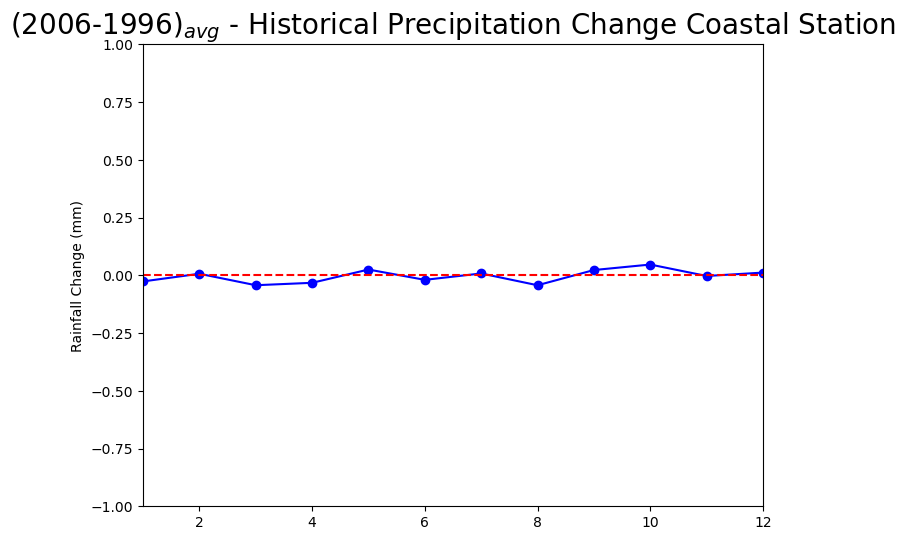

In [725]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-1,1)
ax.plot([1,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Precipitation Change Coastal Station', fontsize=20)
plt.show()

#### Seasonal Means

In [726]:
seasonal_recent = np.round(coastal_change.groupby('season').mean(),1)
seasonal_recent

,Mean_Temp,Total_Rain,Year,Month
season,,,,
DJF,3.9,4.4,1980.0,5.0
JJA,16.9,1.2,1980.0,7.0
MAM,9.4,2.5,1980.0,4.0
SON,10.3,3.8,1980.0,10.0


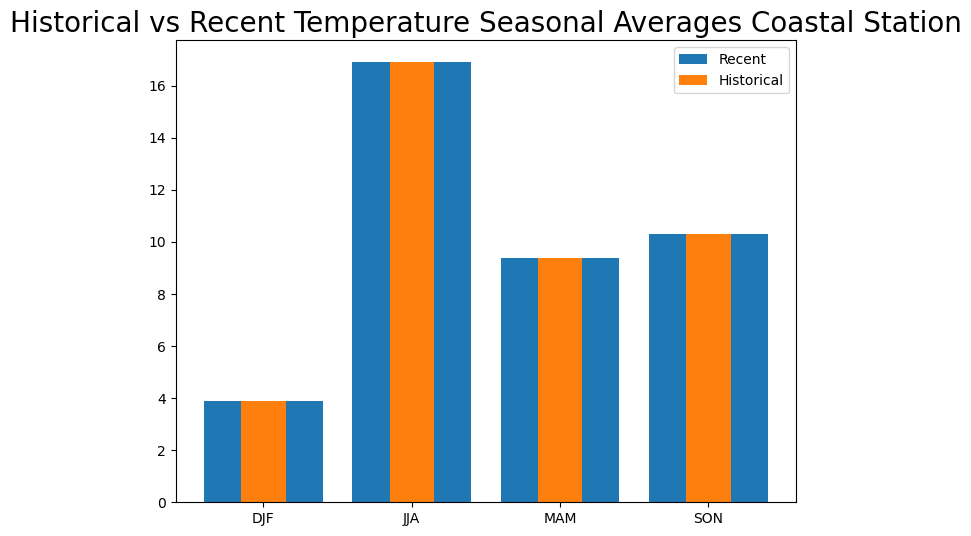

In [727]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
rects= ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
rects_historical = ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages Coastal Station', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [609]:
coastal_30 = clean_coast_data[clean_coast_data['Year'] >= 1938]
coastal_30

,Mean_Temp,Total_Rain,Year,Month,season
datetime,,,,,
1938-01-01,3.33,0.00,1938,1,DJF
1938-02-01,3.97,0.00,1938,2,DJF
1938-03-01,6.05,2.61,1938,3,MAM
1938-04-01,9.15,2.04,1938,4,MAM
1938-05-01,11.81,1.69,1938,5,MAM
...,...,...,...,...,...
2022-08-01,19.80,0.21,2022,8,JJA
2022-09-01,16.02,0.23,2022,9,SON
2022-10-01,12.05,2.86,2022,10,SON


#### Mean Temperature Change

In [610]:
df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1803563369.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)


10.13

In [611]:
Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\914197677.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


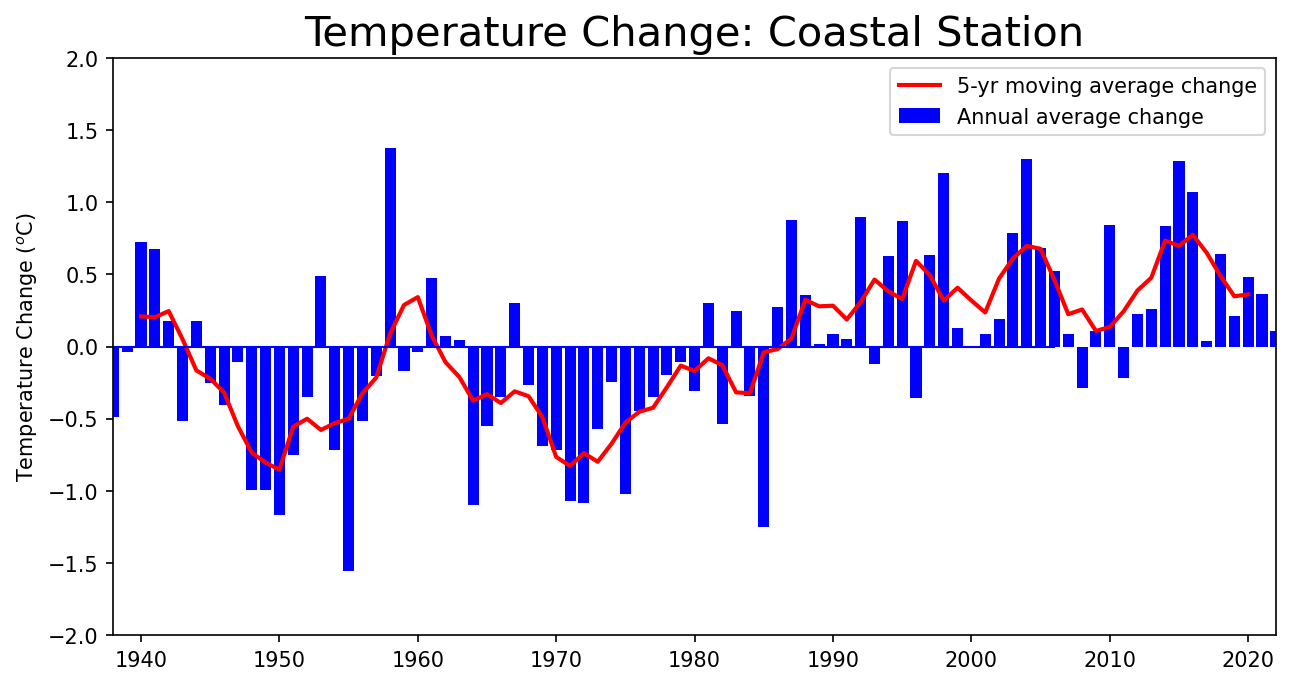

In [618]:
year_val = np.linspace(1938,2022,85)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1938,2022])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-2,2])


plt.title('Temperature Change: Coastal Station', fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [615]:
df_30yrs_Total_Rain = np.round(clean_coast_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\4199653423.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_coast_data.groupby('Year').mean().mean().Total_Rain,2)


2.99

In [616]:
Rdiff = clean_coast_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3090641514.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_coast_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


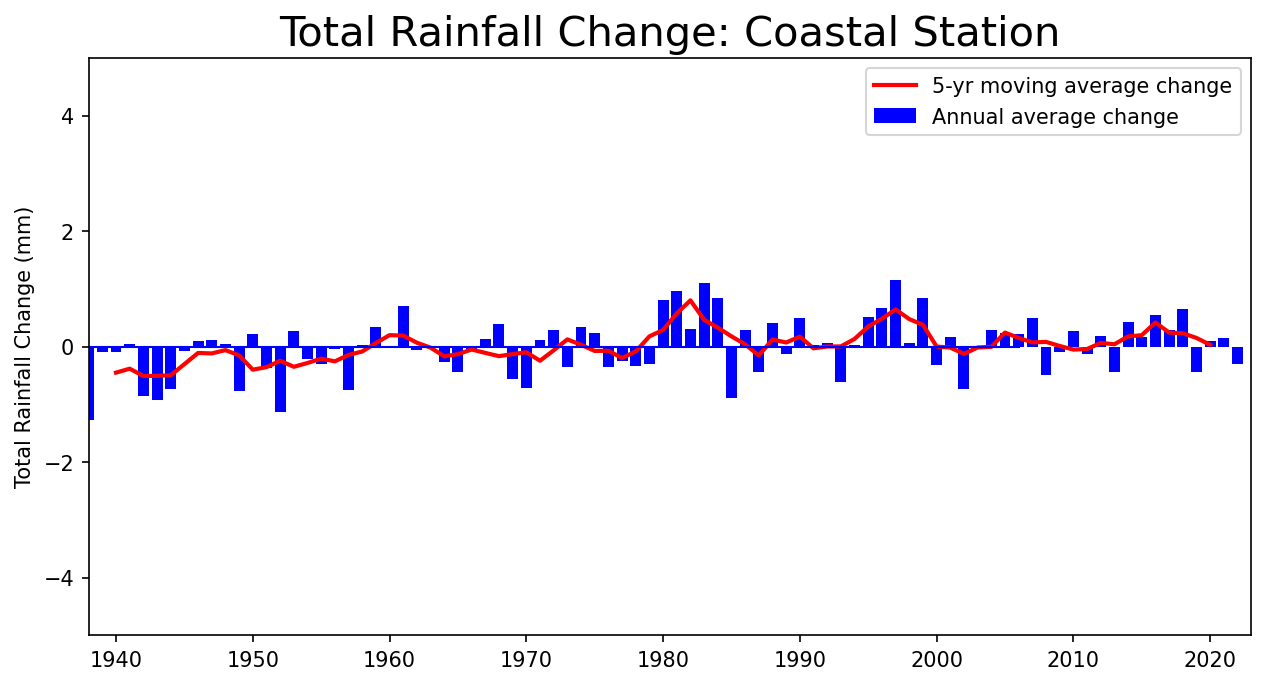

In [621]:
year_val = np.linspace(1938,2022,85)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1938,2023])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-5,5])


plt.title('Total Rainfall Change: Coastal Station', fontsize=20)
plt.legend()
plt.show()

## Central Interior Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

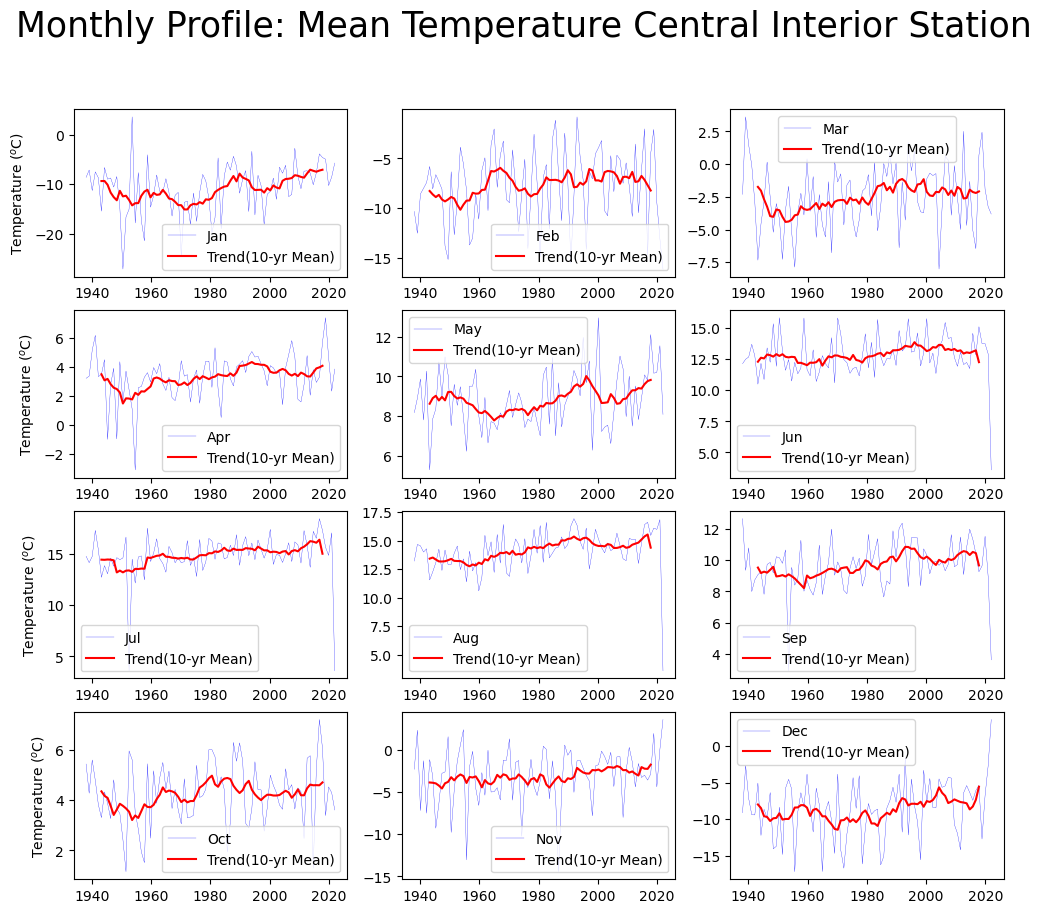

In [630]:
year_val = np.linspace(1938,2022, 82)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_central_data[clean_central_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature Central Interior Station',fontsize=25)
    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

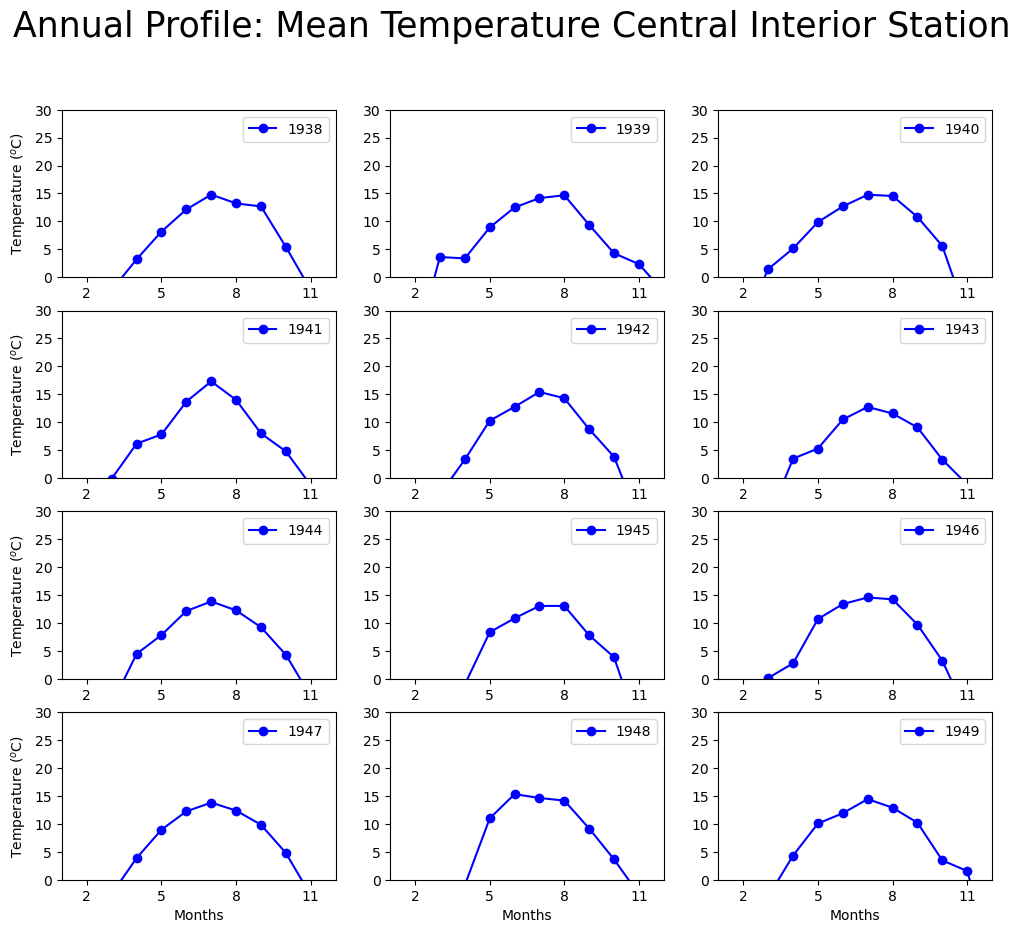

In [631]:
year = np.arange(1938,2022)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_central_data[clean_central_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature Central Interior Station', fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

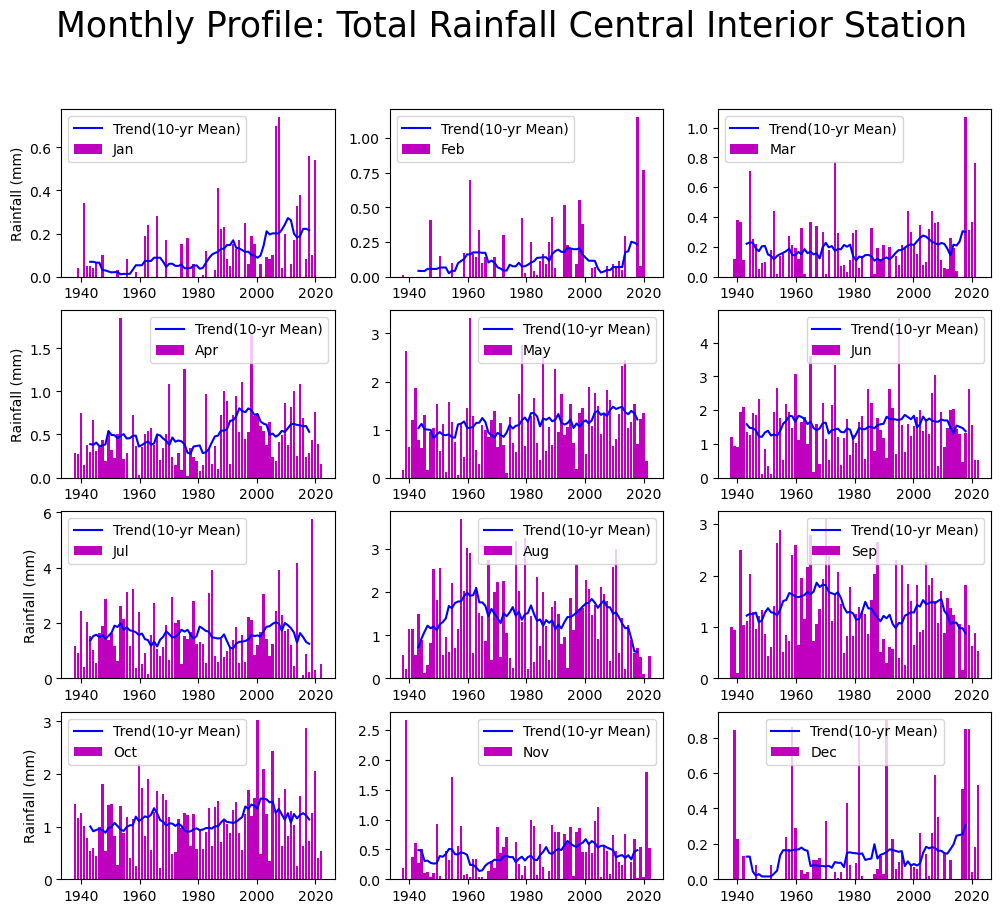

In [633]:
year_val = np.linspace(1938,2022,82)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_central_data[clean_central_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall Central Interior Station',fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

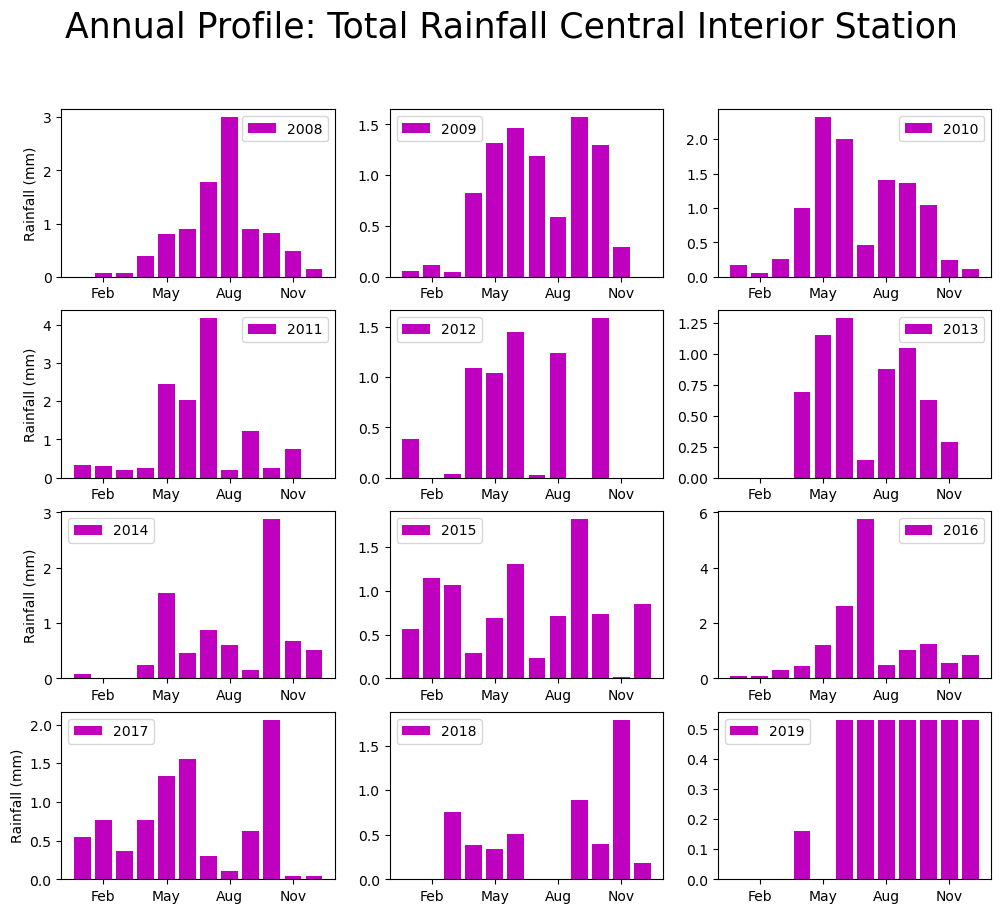

In [732]:
year = np.arange(2008,2020)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_central_data[clean_central_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall Central Interior Station',fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [645]:
Monthly_Mean = np.round(clean_central_data.groupby('Month').mean(),1)

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1770475638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Monthly_Mean = np.round(clean_central_data.groupby('Month').mean(),1)


#### Mean Monthly Temperature

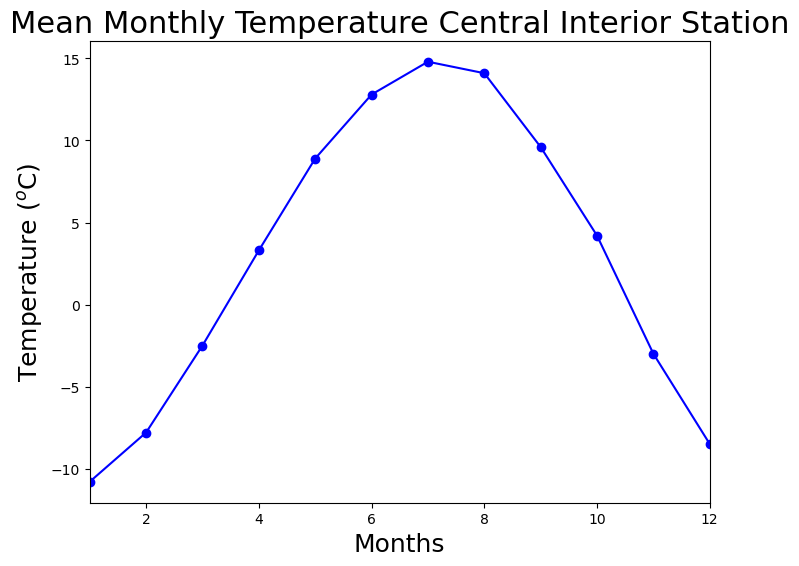

In [647]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature Central Interior Station', fontsize=22)

plt.show()

#### Mean Monthly Rainfall

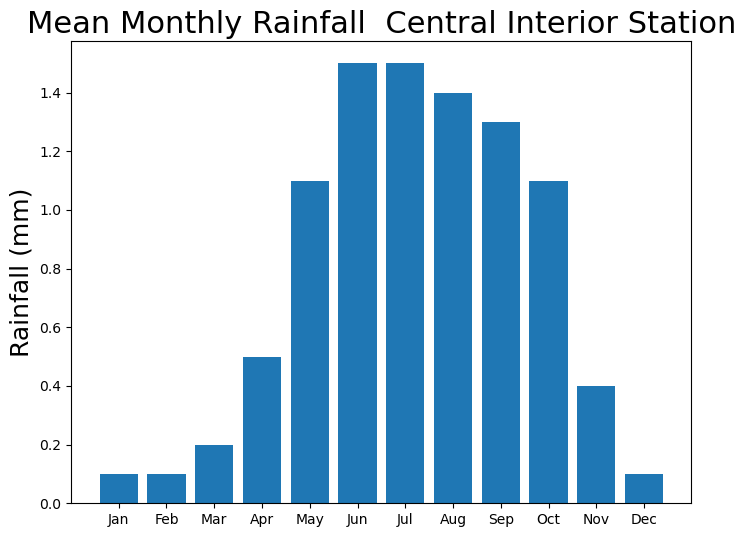

In [648]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall  Central Interior Station', fontsize=22)
plt.show()

### Seasonal Means

In [740]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_central_data['season'] = [month_num_2_season.get(i) for i in clean_central_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_central_data.groupby('season').mean(),1)
seasonal_val


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2139407118.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_central_data['season'] = [month_num_2_season.get(i) for i in clean_central_data.Month]
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2139407118.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_val = np.round(clean_central_data.groupby('season').mean(),1)


,Mean_Temp,Total_Rain,Year,Month
season,,,,
DJF,-9.0,0.1,1978.5,5.0
JJA,13.9,1.5,1978.5,7.0
MAM,3.2,0.6,1978.5,4.0
SON,3.6,1.0,1978.5,10.0


### Data Visualization 10 years

In [741]:
central_recent = clean_central_data[clean_central_data['Year'] >= 1938]
central_recent

,datetime,Mean_Temp,Total_Rain,Year,Month,season
516,1938-01-01,-8.64,0.00,1938,1,DJF
517,1938-02-01,-10.32,0.01,1938,2,DJF
518,1938-03-01,-2.32,0.00,1938,3,MAM
519,1938-04-01,3.20,0.28,1938,4,MAM
520,1938-05-01,8.17,0.16,1938,5,MAM
...,...,...,...,...,...,...
1495,2019-08-01,3.60,0.53,2019,8,JJA
1496,2019-09-01,3.60,0.53,2019,9,SON
1497,2019-10-01,3.60,0.53,2019,10,SON
1498,2019-11-01,3.60,0.53,2019,11,SON


In [742]:
monthly_mean_recent = central_recent.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3062484155.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = central_recent.groupby('Month').mean()


,Mean_Temp,Total_Rain,Year
Month,,,
1,-10.781220,0.104512,1978.5
2,-7.828293,0.115976,1978.5
3,-2.490122,0.193659,1978.5
4,3.320732,0.489878,1978.5
5,8.857195,1.118171,1978.5
6,12.768293,1.516098,1978.5
7,14.837927,1.540488,1978.5
8,14.105610,1.366341,1978.5
9,9.643415,1.320488,1978.5


#### Mean Temperature Change

In [743]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


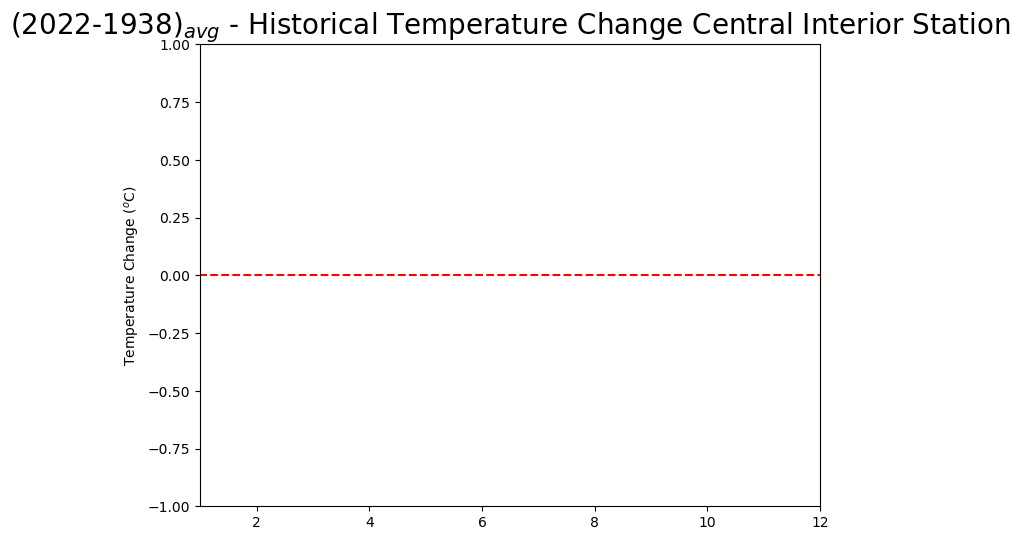

In [744]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-1,1)
ax.plot([0,12],[0,0],'r--')
plt.title('(2022-1938)$_{avg}$ - Historical Temperature Change Central Interior Station', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [745]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

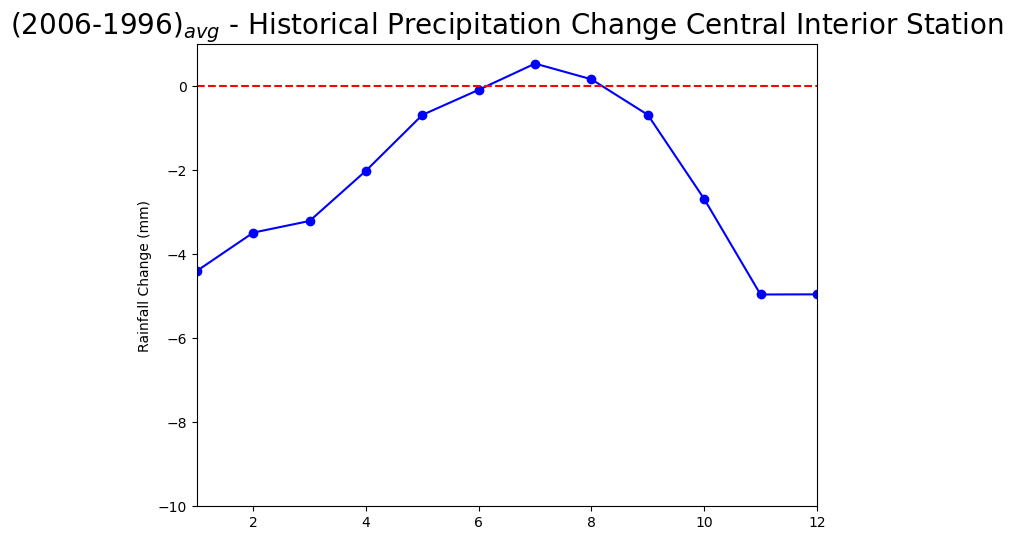

In [747]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-10,1)
ax.plot([1,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Precipitation Change Central Interior Station', fontsize=20)
plt.show()

#### Seasonal Means

In [748]:
seasonal_recent = np.round(central_recent.groupby('season').mean(),1)
seasonal_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\180453069.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_recent = np.round(central_recent.groupby('season').mean(),1)


,Mean_Temp,Total_Rain,Year,Month
season,,,,
DJF,-9.0,0.1,1978.5,5.0
JJA,13.9,1.5,1978.5,7.0
MAM,3.2,0.6,1978.5,4.0
SON,3.6,1.0,1978.5,10.0


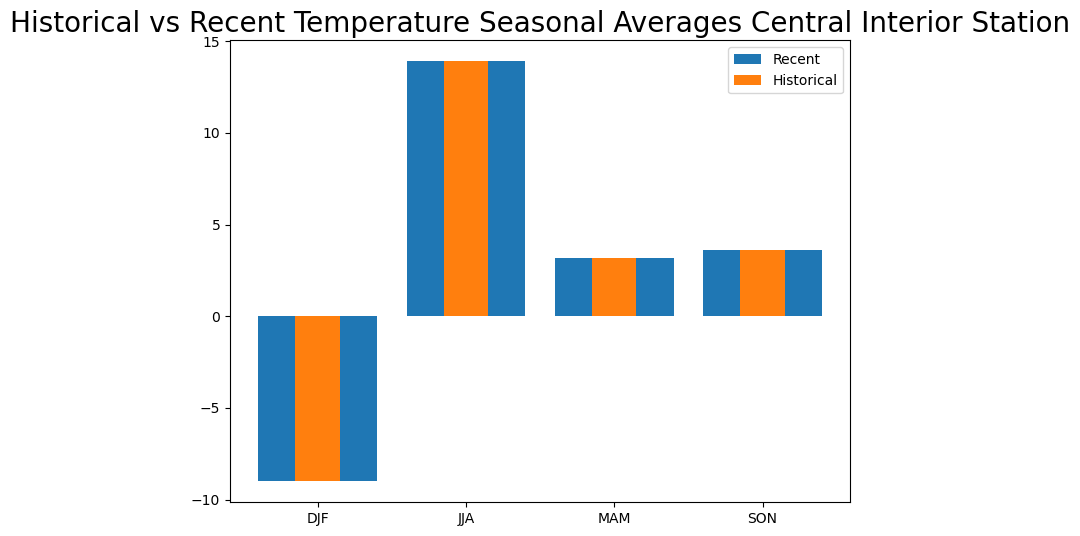

In [749]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
rects = ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
rects_historical = ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages Central Interior Station', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [750]:
central_30 = clean_central_data[clean_central_data['Year'] >= 1938]
central_30

,datetime,Mean_Temp,Total_Rain,Year,Month,season
516,1938-01-01,-8.64,0.00,1938,1,DJF
517,1938-02-01,-10.32,0.01,1938,2,DJF
518,1938-03-01,-2.32,0.00,1938,3,MAM
519,1938-04-01,3.20,0.28,1938,4,MAM
520,1938-05-01,8.17,0.16,1938,5,MAM
...,...,...,...,...,...,...
1495,2019-08-01,3.60,0.53,2019,8,JJA
1496,2019-09-01,3.60,0.53,2019,9,SON
1497,2019-10-01,3.60,0.53,2019,10,SON
1498,2019-11-01,3.60,0.53,2019,11,SON


#### Mean Temperature Change

In [752]:
df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1803563369.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)


10.13

In [753]:
Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\914197677.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


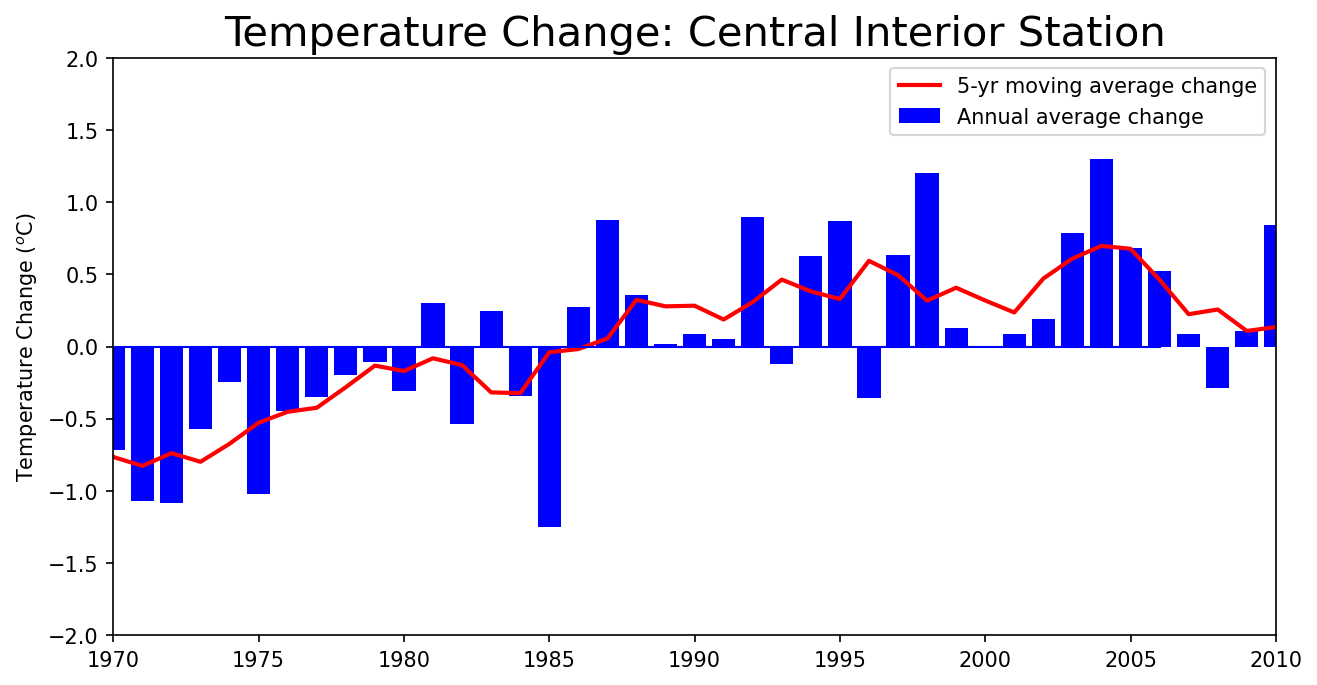

In [754]:
year_val = np.linspace(1938,2022,85)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1970,2010])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-2,2])


plt.title('Temperature Change: Central Interior Station', fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [755]:
df_30yrs_Total_Rain = np.round(clean_central_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1153513781.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_central_data.groupby('Year').mean().mean().Total_Rain,2)


0.79

In [756]:
Rdiff = clean_central_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3898913928.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_central_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


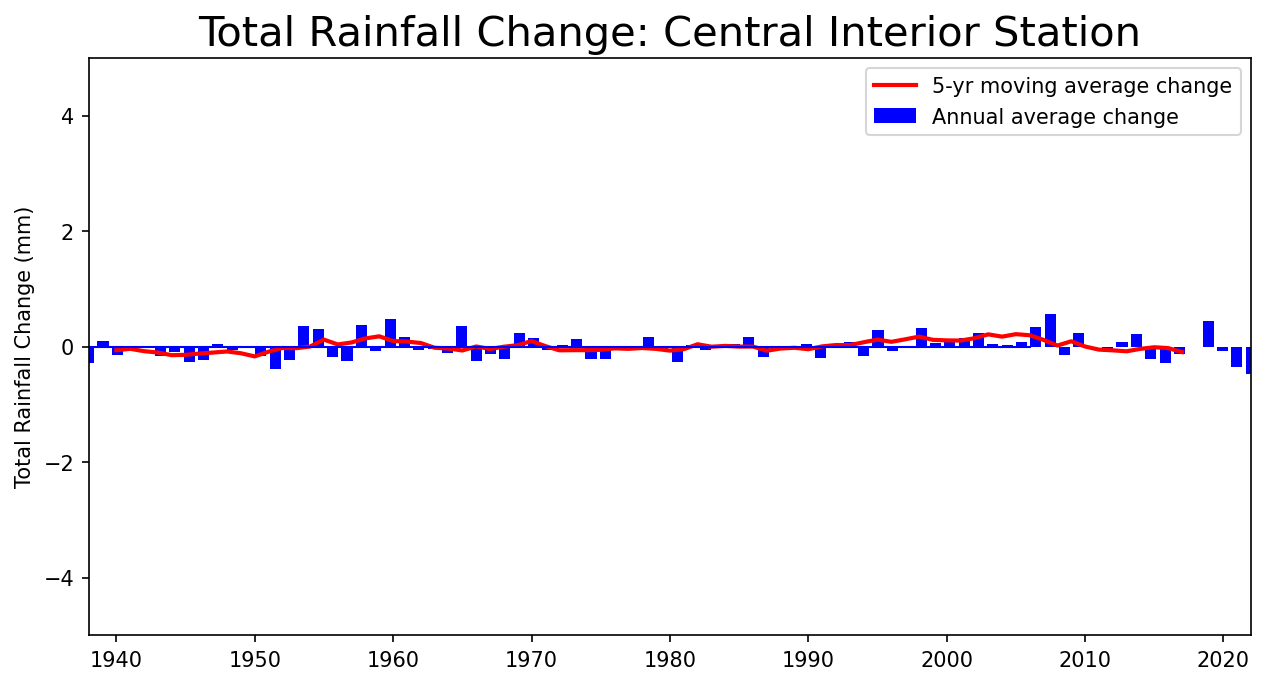

In [757]:
year_val = np.linspace(1938,2022,82)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1938,2022])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-5,5])


plt.title('Total Rainfall Change: Central Interior Station', fontsize=20)
plt.legend()
plt.show()

## Southern Interior Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

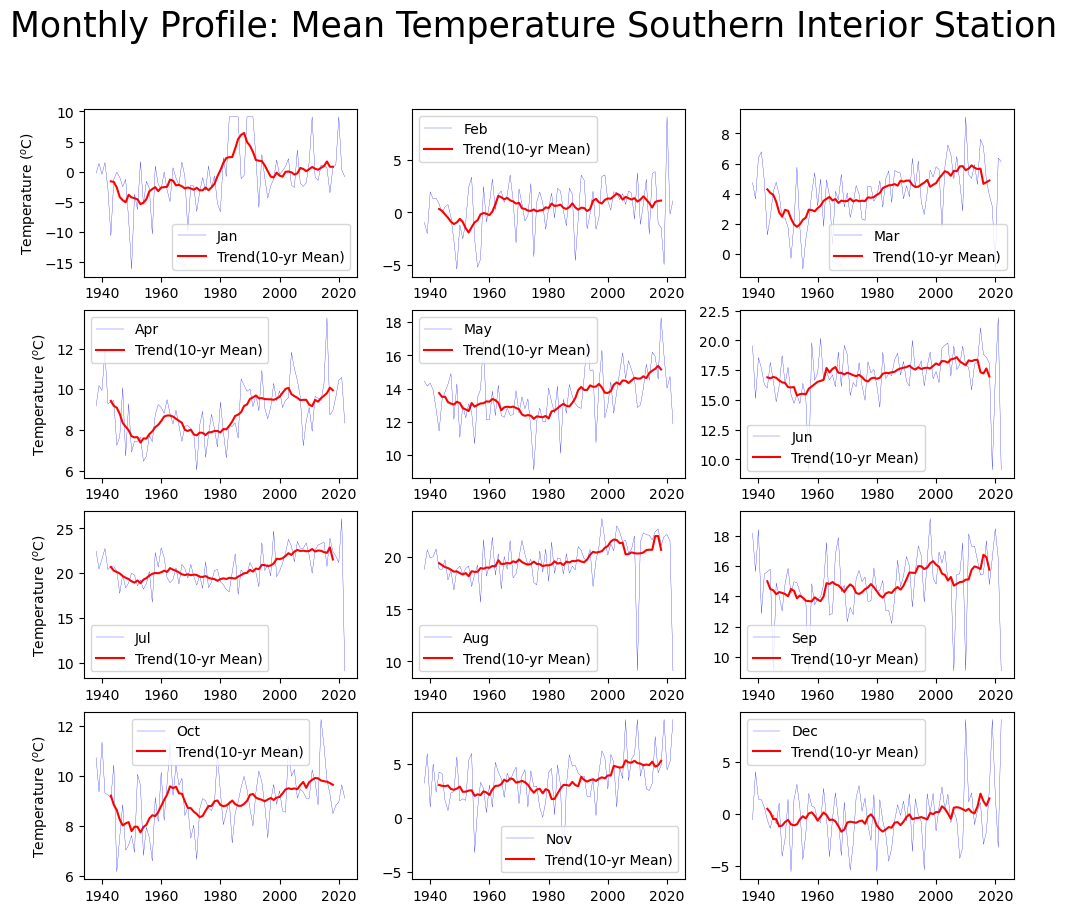

In [682]:
year_val = np.linspace(1938,2022, 85)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_interior_data[clean_interior_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature Southern Interior Station',fontsize=25)
    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

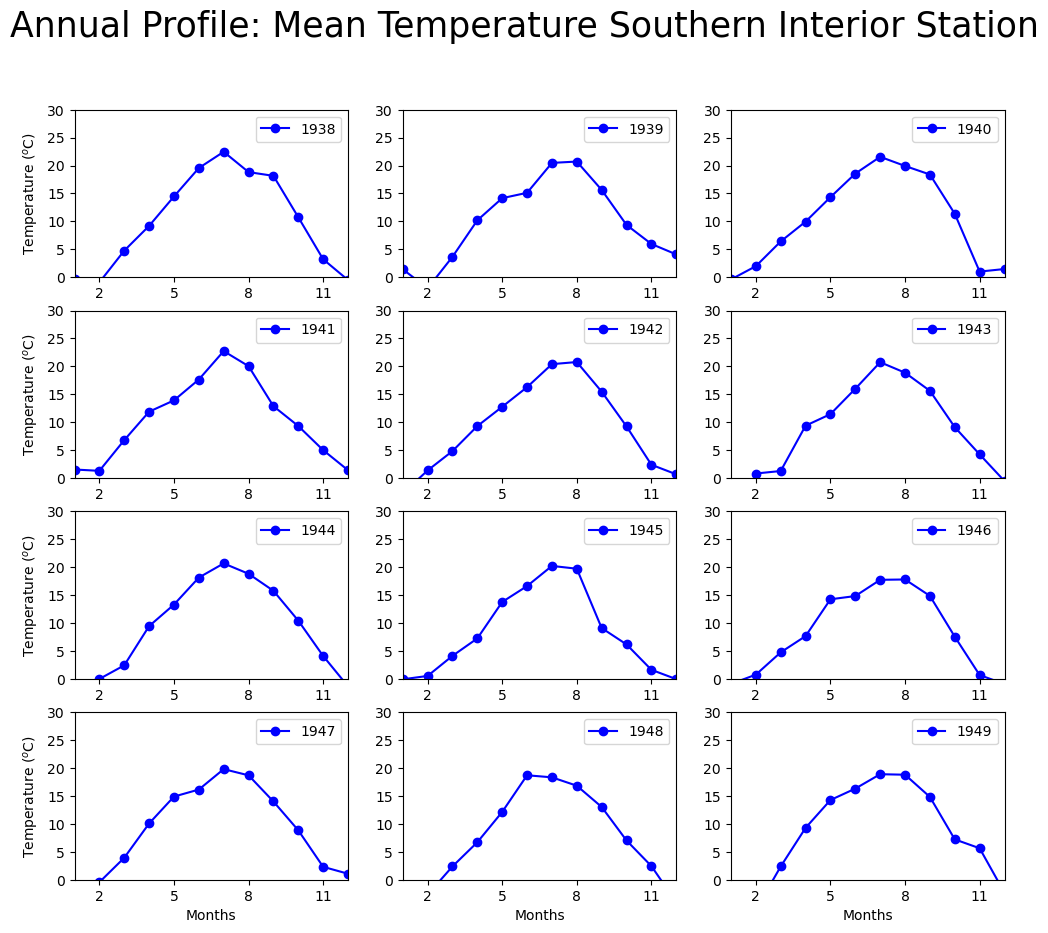

In [683]:
year = np.arange(1938,2022)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_interior_data[clean_interior_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature Southern Interior Station', fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

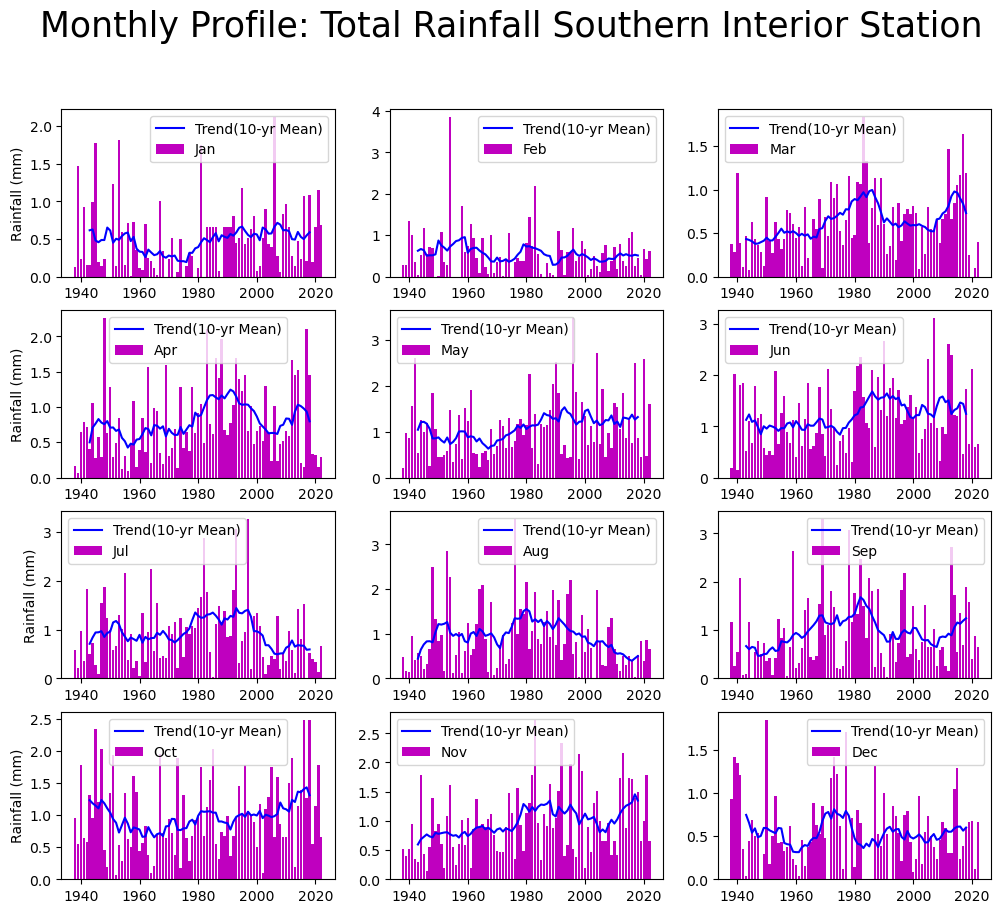

In [684]:
year_val = np.linspace(1938,2022,85)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_interior_data[clean_interior_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall Southern Interior Station',fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

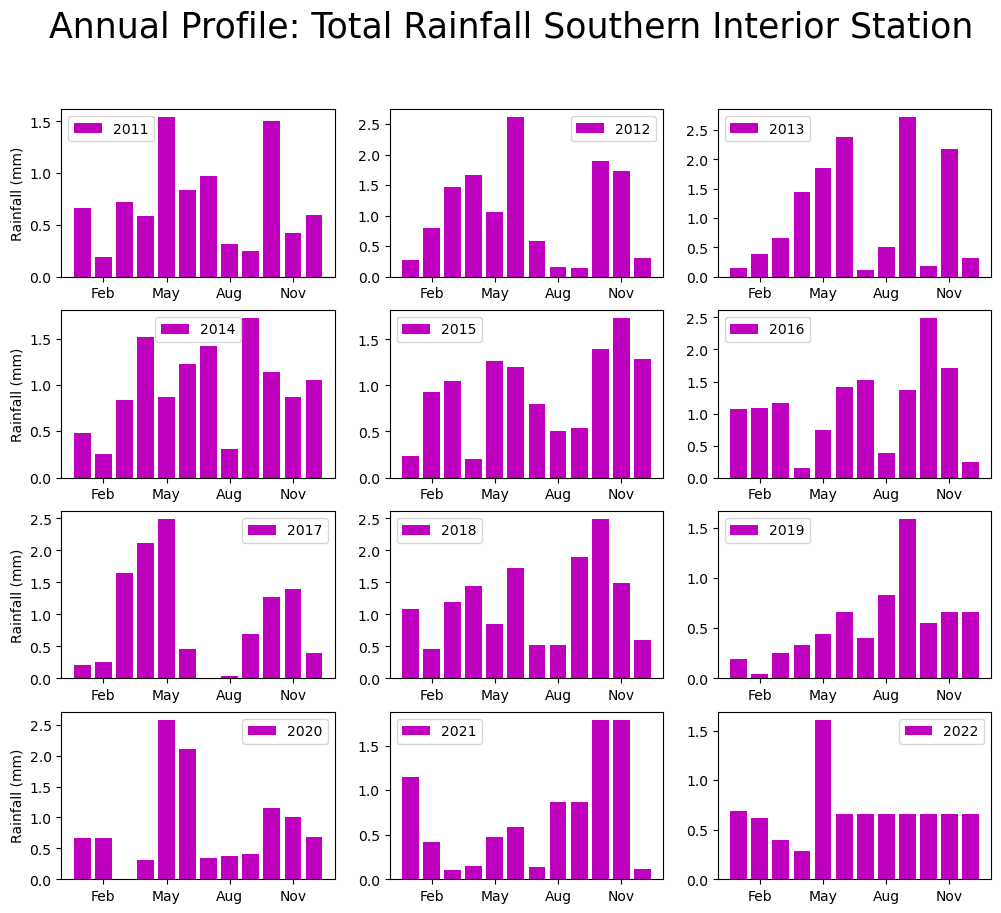

In [686]:
year = np.arange(2011,2023)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_interior_data[clean_interior_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall Southern Interior Station',fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [687]:
Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\617222211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)


#### Mean Monthly Temperature

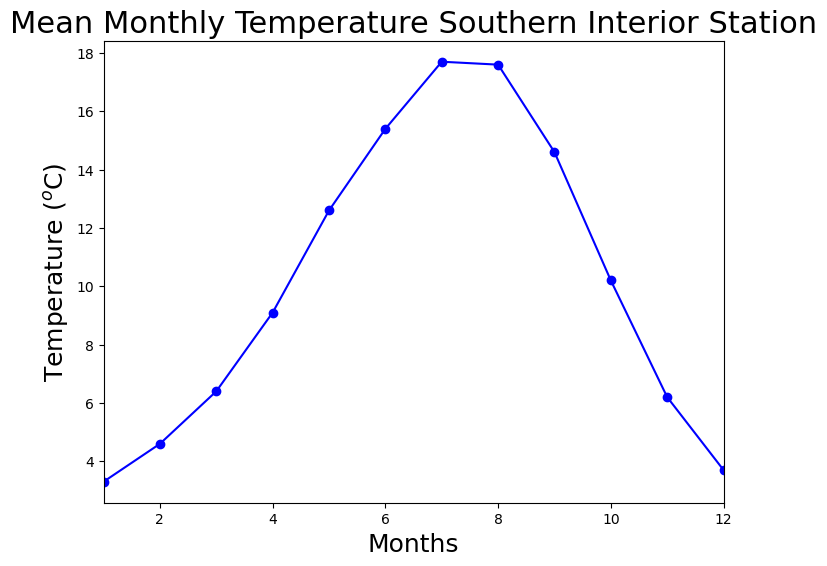

In [688]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature Southern Interior Station', fontsize=22)

plt.show()

#### Mean Monthly Rainfall

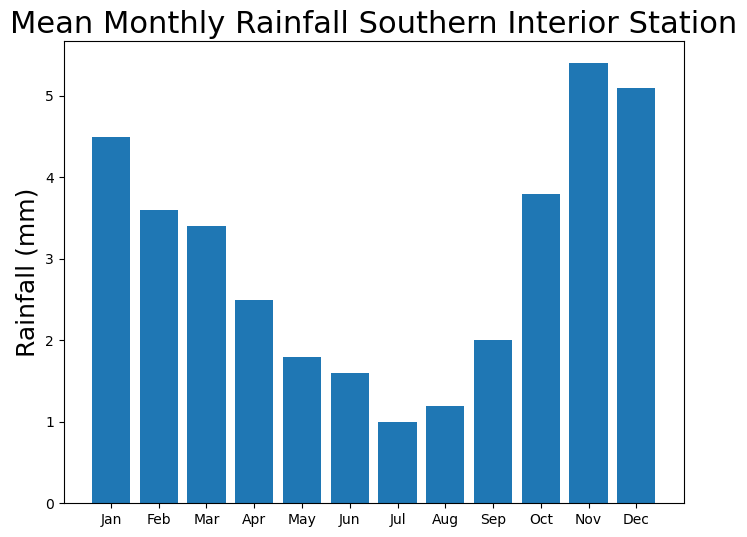

In [689]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall Southern Interior Station', fontsize=22)
plt.show()

### Seasonal Means

In [758]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_interior_data['season'] = [month_num_2_season.get(i) for i in clean_interior_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_interior_data.groupby('season').mean(),1)
seasonal_val


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3392295815.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_interior_data['season'] = [month_num_2_season.get(i) for i in clean_interior_data.Month]
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3392295815.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_val = np.round(clean_interior_data.groupby('season').mean(),1)


,Mean_Temp,Total_Rain,Year,Month
season,,,,
DJF,-0.1,0.5,1980.0,5.0
JJA,19.1,1.0,1980.0,7.0
MAM,8.9,0.8,1980.0,4.0
SON,9.2,1.0,1980.0,10.0


### Data Visualization 10 years

In [759]:
interior_recent = clean_interior_data[clean_interior_data['Year'] >= 1995]
interior_recent

,datetime,Mean_Temp,Total_Rain,Year,Month,season
840,1995-01-01,-0.980,1.18,1995,1,DJF
841,1995-02-01,2.020,0.59,1995,2,DJF
842,1995-03-01,3.450,0.84,1995,3,MAM
843,1995-04-01,9.070,1.22,1995,4,MAM
844,1995-05-01,15.120,0.45,1995,5,MAM
...,...,...,...,...,...,...
1171,2022-08-01,9.105,0.66,2022,8,JJA
1172,2022-09-01,9.105,0.66,2022,9,SON
1173,2022-10-01,9.105,0.66,2022,10,SON
1174,2022-11-01,9.105,0.66,2022,11,SON


In [760]:
monthly_mean_recent = interior_recent.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\281921945.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = interior_recent.groupby('Month').mean()


,Mean_Temp,Total_Rain,Year
Month,,,
1,0.242143,0.611071,2008.5
2,1.205179,0.496071,2008.5
3,5.027679,0.677857,2008.5
4,9.616071,0.786786,2008.5
5,14.460357,1.307857,2008.5
6,17.612857,1.292857,2008.5
7,21.753393,0.725357,2008.5
8,20.600714,0.693929,2008.5
9,15.560179,0.969643,2008.5


#### Mean Temperature Change

In [761]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


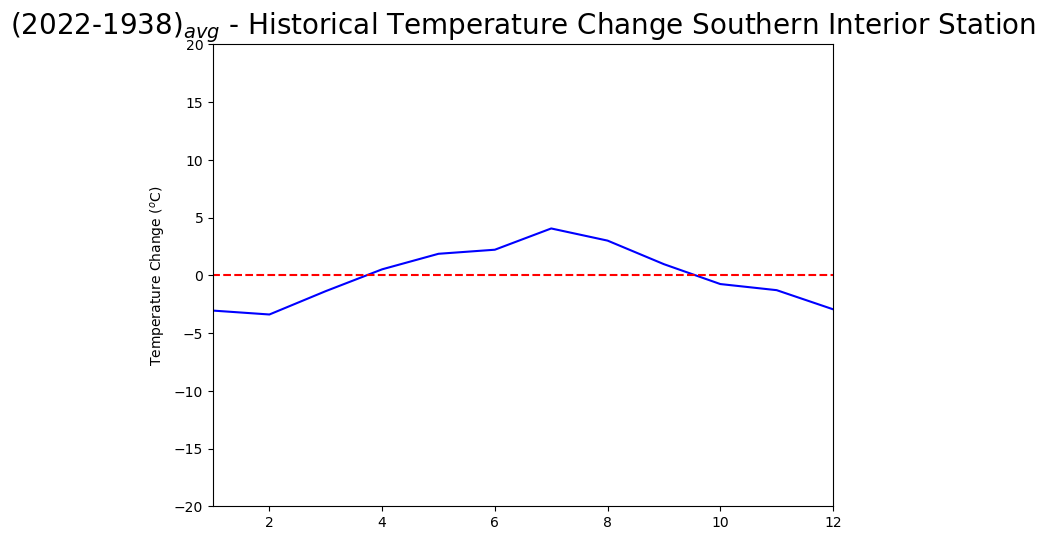

In [762]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-20,20)
ax.plot([0,12],[0,0],'r--')
plt.title('(2022-1938)$_{avg}$ - Historical Temperature Change Southern Interior Station', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [763]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

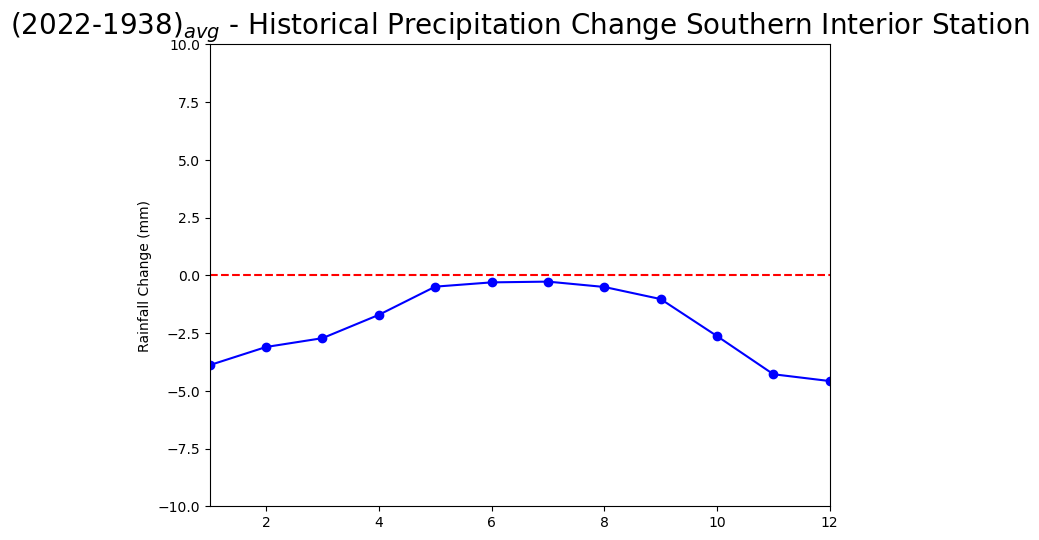

In [764]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-10,10)
ax.plot([1,12],[0,0],'r--')
plt.title('(2022-1938)$_{avg}$ - Historical Precipitation Change Southern Interior Station', fontsize=20)
plt.show()

#### Seasonal Means

In [765]:
seasonal_recent = np.round(interior_recent.groupby('season').mean(),1)
seasonal_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3795880199.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_recent = np.round(interior_recent.groupby('season').mean(),1)


,Mean_Temp,Total_Rain,Year,Month
season,,,,
DJF,0.7,0.5,2008.5,5.0
JJA,20.0,0.9,2008.5,7.0
MAM,9.7,0.9,2008.5,4.0
SON,10.0,1.1,2008.5,10.0


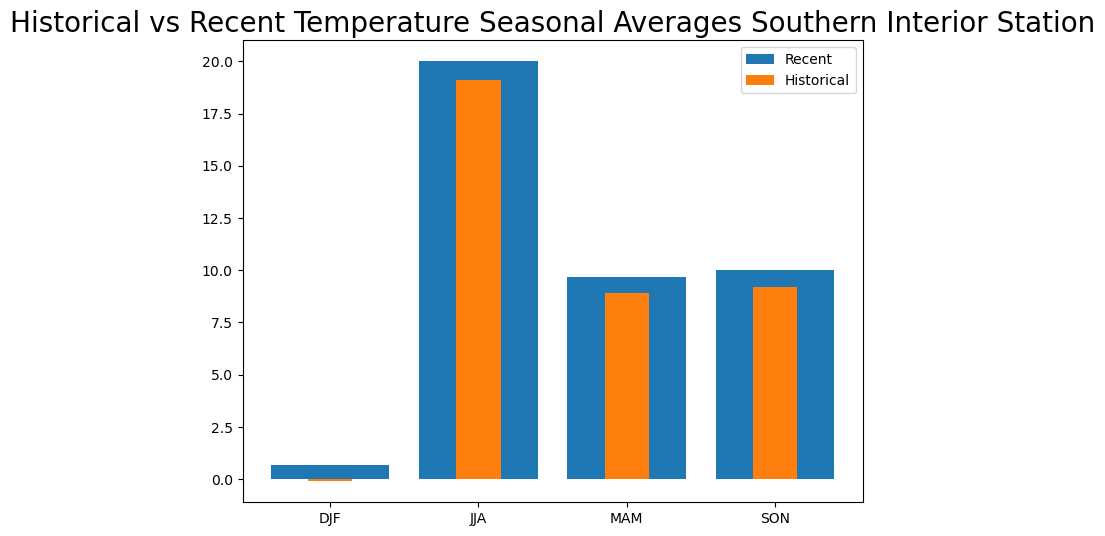

In [766]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
rect = ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
rect_historical = ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages Southern Interior Station', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [767]:
interior_30 = clean_interior_data[clean_interior_data['Year'] >= 1938]
interior_30

,datetime,Mean_Temp,Total_Rain,Year,Month,season
156,1938-01-01,-0.260,0.13,1938,1,DJF
157,1938-02-01,-0.940,0.28,1938,2,DJF
158,1938-03-01,4.740,0.38,1938,3,MAM
159,1938-04-01,9.180,0.17,1938,4,MAM
160,1938-05-01,14.450,0.20,1938,5,MAM
...,...,...,...,...,...,...
1171,2022-08-01,9.105,0.66,2022,8,JJA
1172,2022-09-01,9.105,0.66,2022,9,SON
1173,2022-10-01,9.105,0.66,2022,10,SON
1174,2022-11-01,9.105,0.66,2022,11,SON


#### Mean Temperature Change

In [768]:
df_30yrs_Mean_Temp = np.round(interior_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1559133115.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(interior_30.groupby('Year').mean().mean().Mean_Temp,2)


9.27

In [769]:
Tdiff = clean_interior_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3026043880.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_interior_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


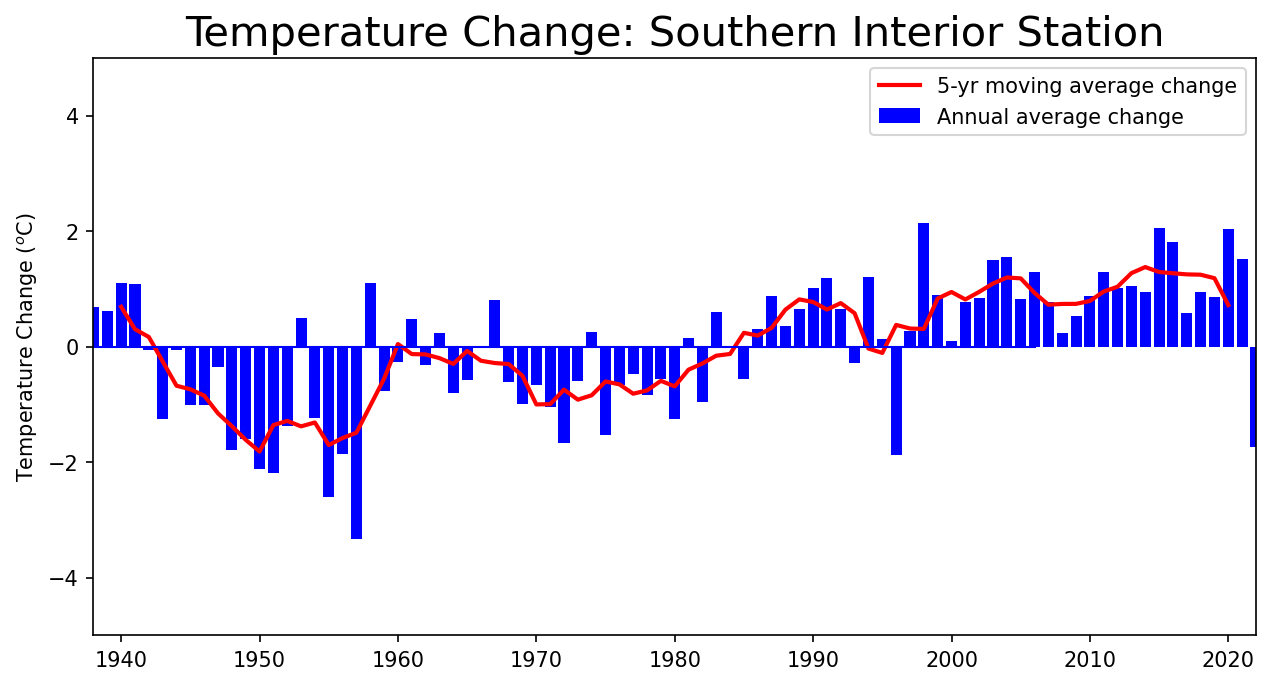

In [770]:
year_val = np.linspace(1938,2022,85)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1938,2022])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-5,5])


plt.title('Temperature Change: Southern Interior Station', fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [707]:
df_30yrs_Total_Rain = np.round(clean_interior_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\376733900.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_interior_data.groupby('Year').mean().mean().Total_Rain,2)


0.84

In [708]:
Rdiff = clean_interior_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1390460375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_interior_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


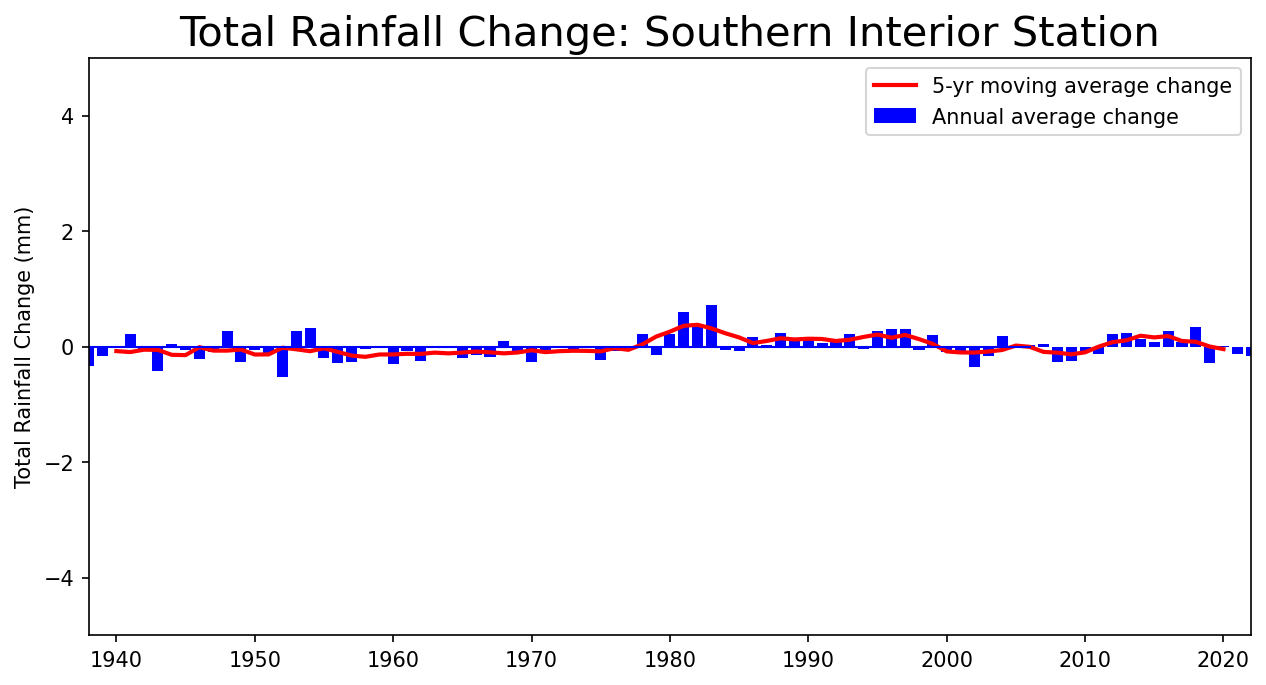

In [710]:
year_val = np.linspace(1938,2022,85)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1938,2022])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-5,5])


plt.title('Total Rainfall Change: Southern Interior Station', fontsize=20)
plt.legend()
plt.show()

# Global Analysis

On it's way

In [711]:
global_temp = pd.read_csv(r'D:\Above\web-dev\projects\climate_analysis_ENSC304\1960-2023.csv')

In [712]:
global_temp['datetime'] = pd.to_datetime(global_temp['Year'], format='%Y%m', errors='ignore')
global_temp_clean['year'] = global_temp['datetime'].dt.strftime('%Y')
global_temp_clean['month'] = global_temp['datetime'].dt.strftime('%m')
global_temp_clean.to_csv('global_temp_clean3.csv')

In [713]:
df_30yrs_Mean_Temp_glob = np.round(global_temp_clean.groupby('year').mean().mean().Value,2)
df_30yrs_Mean_Temp_glob

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2613886671.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp_glob = np.round(global_temp_clean.groupby('year').mean().mean().Value,2)


0.4

In [714]:
Tdiff_global = global_temp_clean.groupby('year').mean().Value - df_30yrs_Mean_Temp_glob

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2268362933.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff_global = global_temp_clean.groupby('year').mean().Value - df_30yrs_Mean_Temp_glob


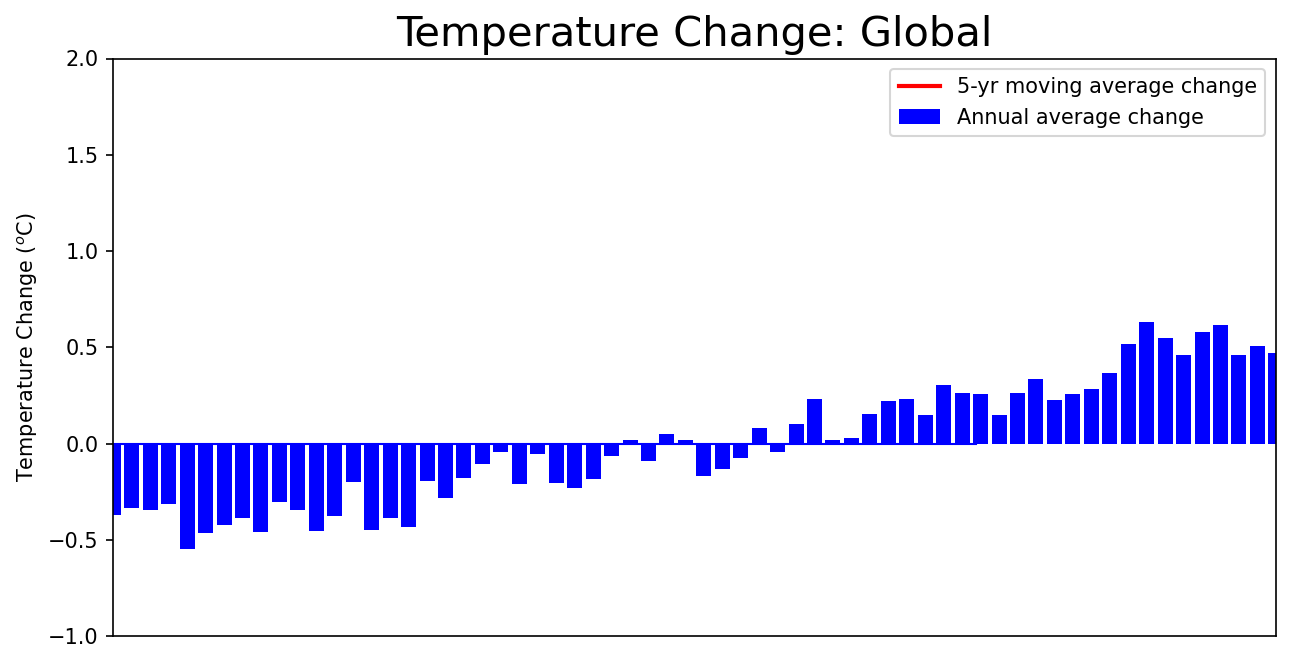

In [715]:
year_val = np.linspace(1960,2022,64)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff_global,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1960,2022])
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.plot(Tdiff_global.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.set_ylim([-1,2])


plt.title('Temperature Change: Global', fontsize=20)
plt.legend()
plt.show()